# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.discrete, source=Source.all, past=Past.all, durl=Durl.all, max_distance=2)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 87568 substitutions for model Model(time=Time.discrete, source=Source.all, past=Past.all, durl=Durl.all, max_distance=2)


  0% (    1 of 87568) |            | Elapsed Time: 0:00:04 ETA:  4 days, 4:35:08

  0% (   85 of 87568) |                    | Elapsed Time: 0:00:05 ETA:  0:17:18

  0% (  166 of 87568) |                    | Elapsed Time: 0:00:06 ETA:  0:17:36

  0% (  259 of 87568) |                    | Elapsed Time: 0:00:07 ETA:  0:16:55

  0% (  346 of 87568) |                    | Elapsed Time: 0:00:08 ETA:  0:16:51

  0% (  432 of 87568) |                    | Elapsed Time: 0:00:09 ETA:  0:16:50

  0% (  518 of 87568) |                    | Elapsed Time: 0:00:10 ETA:  0:16:49

  0% (  606 of 87568) |                    | Elapsed Time: 0:00:11 ETA:  0:16:45

  0% (  695 of 87568) |                    | Elapsed Time: 0:00:12 ETA:  0:16:41

  0% (  782 of 87568) |                    | Elapsed Time: 0:00:13 ETA:  0:16:41

  0% (  866 of 87568) |                    | Elapsed Time: 0:00:14 ETA:  0:16:41

  1% (  950 of 87568) |                    | Elapsed Time: 0:00:15 ETA:  0:16:36

  1% ( 1034 of 87568) |                    | Elapsed Time: 0:00:16 ETA:  0:16:47

  1% ( 1095 of 87568) |                    | Elapsed Time: 0:00:16 ETA:  0:16:47

  1% ( 1179 of 87568) |                    | Elapsed Time: 0:00:17 ETA:  0:16:50

  1% ( 1269 of 87568) |                    | Elapsed Time: 0:00:18 ETA:  0:16:44

  1% ( 1360 of 87568) |                    | Elapsed Time: 0:00:19 ETA:  0:16:38

  1% ( 1451 of 87568) |                    | Elapsed Time: 0:00:20 ETA:  0:16:34

  1% ( 1541 of 87568) |                    | Elapsed Time: 0:00:21 ETA:  0:16:29

  1% ( 1631 of 87568) |                    | Elapsed Time: 0:00:22 ETA:  0:16:19

  1% ( 1721 of 87568) |                    | Elapsed Time: 0:00:23 ETA:  0:16:10

  2% ( 1811 of 87568) |                    | Elapsed Time: 0:00:24 ETA:  0:16:00

  2% ( 1871 of 87568) |                    | Elapsed Time: 0:00:25 ETA:  0:16:35

  2% ( 1961 of 87568) |                    | Elapsed Time: 0:00:26 ETA:  0:16:25

  2% ( 2049 of 87568) |                    | Elapsed Time: 0:00:27 ETA:  0:16:28

  2% ( 2138 of 87568) |                    | Elapsed Time: 0:00:28 ETA:  0:16:30

  2% ( 2190 of 87568) |                    | Elapsed Time: 0:00:29 ETA:  0:16:36

  2% ( 2277 of 87568) |                    | Elapsed Time: 0:00:30 ETA:  0:16:39

  2% ( 2368 of 87568) |                    | Elapsed Time: 0:00:31 ETA:  0:16:36

  2% ( 2454 of 87568) |                    | Elapsed Time: 0:00:32 ETA:  0:16:41

  2% ( 2542 of 87568) |                    | Elapsed Time: 0:00:33 ETA:  0:16:43

  3% ( 2635 of 87568) |                    | Elapsed Time: 0:00:34 ETA:  0:15:57

  3% ( 2723 of 87568) |                    | Elapsed Time: 0:00:35 ETA:  0:15:59

  3% ( 2811 of 87568) |                    | Elapsed Time: 0:00:36 ETA:  0:15:57

  3% ( 2896 of 87568) |                    | Elapsed Time: 0:00:37 ETA:  0:16:01

  3% ( 2988 of 87568) |                    | Elapsed Time: 0:00:38 ETA:  0:15:54

  3% ( 3071 of 87568) |                    | Elapsed Time: 0:00:39 ETA:  0:15:58

  3% ( 3141 of 87568) |                    | Elapsed Time: 0:00:40 ETA:  0:16:24

  3% ( 3233 of 87568) |                    | Elapsed Time: 0:00:41 ETA:  0:16:14

  3% ( 3284 of 87568) |                    | Elapsed Time: 0:00:42 ETA:  0:16:09

  3% ( 3379 of 87568) |                    | Elapsed Time: 0:00:43 ETA:  0:16:05

  3% ( 3469 of 87568) |                    | Elapsed Time: 0:00:44 ETA:  0:16:03

  4% ( 3554 of 87568) |                    | Elapsed Time: 0:00:45 ETA:  0:16:05

  4% ( 3638 of 87568) |                    | Elapsed Time: 0:00:46 ETA:  0:16:06

  4% ( 3721 of 87568) |                    | Elapsed Time: 0:00:47 ETA:  0:16:17

  4% ( 3802 of 87568) |                    | Elapsed Time: 0:00:48 ETA:  0:16:19

  4% ( 3888 of 87568) |                    | Elapsed Time: 0:00:49 ETA:  0:15:56

  4% ( 3976 of 87568) |                    | Elapsed Time: 0:00:50 ETA:  0:16:01

  4% ( 4063 of 87568) |                    | Elapsed Time: 0:00:51 ETA:  0:16:06

  4% ( 4151 of 87568) |                    | Elapsed Time: 0:00:52 ETA:  0:16:15

  4% ( 4238 of 87568) |                    | Elapsed Time: 0:00:53 ETA:  0:16:17

  4% ( 4292 of 87568) |                    | Elapsed Time: 0:00:54 ETA:  0:17:00

  5% ( 4379 of 87568) |#                   | Elapsed Time: 0:00:55 ETA:  0:17:00

  5% ( 4467 of 87568) |#                   | Elapsed Time: 0:00:56 ETA:  0:16:47

  5% ( 4555 of 87568) |#                   | Elapsed Time: 0:00:57 ETA:  0:16:44

  5% ( 4642 of 87568) |#                   | Elapsed Time: 0:00:58 ETA:  0:16:45

  5% ( 4726 of 87568) |#                   | Elapsed Time: 0:00:59 ETA:  0:16:48

  5% ( 4806 of 87568) |#                   | Elapsed Time: 0:01:00 ETA:  0:16:59

  5% ( 4887 of 87568) |#                   | Elapsed Time: 0:01:01 ETA:  0:17:08

  5% ( 4968 of 87568) |#                   | Elapsed Time: 0:01:02 ETA:  0:16:26

  5% ( 5049 of 87568) |#                   | Elapsed Time: 0:01:03 ETA:  0:16:30

  5% ( 5131 of 87568) |#                   | Elapsed Time: 0:01:04 ETA:  0:16:31

  5% ( 5213 of 87568) |#                   | Elapsed Time: 0:01:05 ETA:  0:16:38

  6% ( 5295 of 87568) |#                   | Elapsed Time: 0:01:06 ETA:  0:16:46

  6% ( 5376 of 87568) |#                   | Elapsed Time: 0:01:07 ETA:  0:16:53

  6% ( 5440 of 87568) |#                   | Elapsed Time: 0:01:08 ETA:  0:17:23

  6% ( 5473 of 87568) |#                   | Elapsed Time: 0:01:08 ETA:  0:17:36

  6% ( 5538 of 87568) |#                   | Elapsed Time: 0:01:09 ETA:  0:18:03

  6% ( 5606 of 87568) |#                   | Elapsed Time: 0:01:10 ETA:  0:18:23

  6% ( 5685 of 87568) |#                   | Elapsed Time: 0:01:11 ETA:  0:18:26

  6% ( 5764 of 87568) |#                   | Elapsed Time: 0:01:12 ETA:  0:18:31

  6% ( 5843 of 87568) |#                   | Elapsed Time: 0:01:13 ETA:  0:18:36

  6% ( 5924 of 87568) |#                   | Elapsed Time: 0:01:14 ETA:  0:18:36

  6% ( 6018 of 87568) |#                   | Elapsed Time: 0:01:15 ETA:  0:18:11

  6% ( 6116 of 87568) |#                   | Elapsed Time: 0:01:16 ETA:  0:17:12

  7% ( 6189 of 87568) |#                   | Elapsed Time: 0:01:17 ETA:  0:17:09

  7% ( 6266 of 87568) |#                   | Elapsed Time: 0:01:18 ETA:  0:16:50

  7% ( 6344 of 87568) |#                   | Elapsed Time: 0:01:19 ETA:  0:16:34

  7% ( 6423 of 87568) |#                   | Elapsed Time: 0:01:20 ETA:  0:16:32

  7% ( 6499 of 87568) |#                   | Elapsed Time: 0:01:21 ETA:  0:16:35

  7% ( 6568 of 87568) |#                   | Elapsed Time: 0:01:22 ETA:  0:16:41

  7% ( 6649 of 87568) |#                   | Elapsed Time: 0:01:23 ETA:  0:16:40

  7% ( 6728 of 87568) |#                   | Elapsed Time: 0:01:24 ETA:  0:17:02

  7% ( 6807 of 87568) |#                   | Elapsed Time: 0:01:25 ETA:  0:17:32

  7% ( 6887 of 87568) |#                   | Elapsed Time: 0:01:26 ETA:  0:17:21

  7% ( 6965 of 87568) |#                   | Elapsed Time: 0:01:27 ETA:  0:17:19

  8% ( 7033 of 87568) |#                   | Elapsed Time: 0:01:28 ETA:  0:17:34

  8% ( 7118 of 87568) |#                   | Elapsed Time: 0:01:29 ETA:  0:17:23

  8% ( 7173 of 87568) |#                   | Elapsed Time: 0:01:30 ETA:  0:17:57

  8% ( 7262 of 87568) |#                   | Elapsed Time: 0:01:31 ETA:  0:17:32

  8% ( 7366 of 87568) |#                   | Elapsed Time: 0:01:32 ETA:  0:16:54

  8% ( 7426 of 87568) |#                   | Elapsed Time: 0:01:34 ETA:  0:17:24

  8% ( 7486 of 87568) |#                   | Elapsed Time: 0:01:35 ETA:  0:17:55

  8% ( 7546 of 87568) |#                   | Elapsed Time: 0:01:36 ETA:  0:18:29

  8% ( 7626 of 87568) |#                   | Elapsed Time: 0:01:37 ETA:  0:18:23

  8% ( 7663 of 87568) |#                   | Elapsed Time: 0:01:37 ETA:  0:17:56

  8% ( 7738 of 87568) |#                   | Elapsed Time: 0:01:38 ETA:  0:18:14

  8% ( 7808 of 87568) |#                   | Elapsed Time: 0:01:39 ETA:  0:17:44

  8% ( 7874 of 87568) |#                   | Elapsed Time: 0:01:40 ETA:  0:18:26

  9% ( 7942 of 87568) |#                   | Elapsed Time: 0:01:41 ETA:  0:19:41

  9% ( 8023 of 87568) |#                   | Elapsed Time: 0:01:42 ETA:  0:18:53

  9% ( 8126 of 87568) |#                   | Elapsed Time: 0:01:43 ETA:  0:17:28

  9% ( 8216 of 87568) |#                   | Elapsed Time: 0:01:44 ETA:  0:16:35

  9% ( 8301 of 87568) |#                   | Elapsed Time: 0:01:45 ETA:  0:16:27

  9% ( 8386 of 87568) |#                   | Elapsed Time: 0:01:46 ETA:  0:16:29

  9% ( 8471 of 87568) |#                   | Elapsed Time: 0:01:47 ETA:  0:16:14

  9% ( 8556 of 87568) |#                   | Elapsed Time: 0:01:48 ETA:  0:15:51

  9% ( 8642 of 87568) |#                   | Elapsed Time: 0:01:49 ETA:  0:15:23

  9% ( 8727 of 87568) |#                   | Elapsed Time: 0:01:50 ETA:  0:14:59

 10% ( 8757 of 87568) |##                  | Elapsed Time: 0:01:50 ETA:  0:15:03

 10% ( 8836 of 87568) |##                  | Elapsed Time: 0:01:51 ETA:  0:15:37

 10% ( 8923 of 87568) |##                  | Elapsed Time: 0:01:52 ETA:  0:15:40

 10% ( 9031 of 87568) |##                  | Elapsed Time: 0:01:53 ETA:  0:15:06

 10% ( 9132 of 87568) |##                  | Elapsed Time: 0:01:54 ETA:  0:14:43

 10% ( 9206 of 87568) |##                  | Elapsed Time: 0:01:55 ETA:  0:14:57

 10% ( 9278 of 87568) |##                  | Elapsed Time: 0:01:56 ETA:  0:15:14

 10% ( 9357 of 87568) |##                  | Elapsed Time: 0:01:57 ETA:  0:15:22

 10% ( 9440 of 87568) |##                  | Elapsed Time: 0:01:58 ETA:  0:15:24

 10% ( 9519 of 87568) |##                  | Elapsed Time: 0:01:59 ETA:  0:15:19

 10% ( 9598 of 87568) |##                  | Elapsed Time: 0:02:00 ETA:  0:15:18

 11% ( 9681 of 87568) |##                  | Elapsed Time: 0:02:01 ETA:  0:15:22

 11% ( 9764 of 87568) |##                  | Elapsed Time: 0:02:02 ETA:  0:15:56

 11% ( 9852 of 87568) |##                  | Elapsed Time: 0:02:04 ETA:  0:16:11

 11% ( 9932 of 87568) |##                  | Elapsed Time: 0:02:05 ETA:  0:15:56

 11% (10012 of 87568) |##                  | Elapsed Time: 0:02:06 ETA:  0:15:54

 11% (10091 of 87568) |##                  | Elapsed Time: 0:02:07 ETA:  0:16:01

 11% (10168 of 87568) |##                  | Elapsed Time: 0:02:08 ETA:  0:16:03

 11% (10246 of 87568) |##                  | Elapsed Time: 0:02:09 ETA:  0:16:04

 11% (10319 of 87568) |##                  | Elapsed Time: 0:02:10 ETA:  0:16:20

 11% (10398 of 87568) |##                  | Elapsed Time: 0:02:11 ETA:  0:16:27

 11% (10481 of 87568) |##                  | Elapsed Time: 0:02:12 ETA:  0:16:28

 12% (10548 of 87568) |##                  | Elapsed Time: 0:02:13 ETA:  0:17:29

 12% (10626 of 87568) |##                  | Elapsed Time: 0:02:14 ETA:  0:17:33

 12% (10708 of 87568) |##                  | Elapsed Time: 0:02:15 ETA:  0:17:29

 12% (10789 of 87568) |##                  | Elapsed Time: 0:02:16 ETA:  0:17:24

 12% (10867 of 87568) |##                  | Elapsed Time: 0:02:17 ETA:  0:17:22

 12% (10946 of 87568) |##                  | Elapsed Time: 0:02:18 ETA:  0:17:14

 12% (11030 of 87568) |##                  | Elapsed Time: 0:02:19 ETA:  0:16:55

 12% (11113 of 87568) |##                  | Elapsed Time: 0:02:20 ETA:  0:16:47

 12% (11198 of 87568) |##                  | Elapsed Time: 0:02:21 ETA:  0:16:43

 12% (11279 of 87568) |##                  | Elapsed Time: 0:02:22 ETA:  0:15:39

 12% (11363 of 87568) |##                  | Elapsed Time: 0:02:23 ETA:  0:15:28

 13% (11442 of 87568) |##                  | Elapsed Time: 0:02:24 ETA:  0:15:31

 13% (11526 of 87568) |##                  | Elapsed Time: 0:02:25 ETA:  0:15:25

 13% (11608 of 87568) |##                  | Elapsed Time: 0:02:26 ETA:  0:15:18

 13% (11691 of 87568) |##                  | Elapsed Time: 0:02:27 ETA:  0:15:17

 13% (11769 of 87568) |##                  | Elapsed Time: 0:02:28 ETA:  0:15:25

 13% (11854 of 87568) |##                  | Elapsed Time: 0:02:29 ETA:  0:15:20

 13% (11937 of 87568) |##                  | Elapsed Time: 0:02:30 ETA:  0:15:22

 13% (12041 of 87568) |##                  | Elapsed Time: 0:02:31 ETA:  0:15:13

 13% (12115 of 87568) |##                  | Elapsed Time: 0:02:32 ETA:  0:15:21

 13% (12189 of 87568) |##                  | Elapsed Time: 0:02:33 ETA:  0:15:35

 14% (12260 of 87568) |##                  | Elapsed Time: 0:02:34 ETA:  0:15:53

 14% (12339 of 87568) |##                  | Elapsed Time: 0:02:35 ETA:  0:15:59

 14% (12427 of 87568) |##                  | Elapsed Time: 0:02:36 ETA:  0:15:41

 14% (12507 of 87568) |##                  | Elapsed Time: 0:02:37 ETA:  0:15:49

 14% (12583 of 87568) |##                  | Elapsed Time: 0:02:38 ETA:  0:16:00

 14% (12674 of 87568) |##                  | Elapsed Time: 0:02:39 ETA:  0:15:50

 14% (12756 of 87568) |##                  | Elapsed Time: 0:02:40 ETA:  0:15:49

 14% (12842 of 87568) |##                  | Elapsed Time: 0:02:41 ETA:  0:15:29

 14% (12933 of 87568) |##                  | Elapsed Time: 0:02:42 ETA:  0:15:03

 14% (13022 of 87568) |##                  | Elapsed Time: 0:02:43 ETA:  0:14:38

 14% (13105 of 87568) |##                  | Elapsed Time: 0:02:44 ETA:  0:14:30

 15% (13136 of 87568) |###                 | Elapsed Time: 0:02:45 ETA:  0:14:45

 15% (13208 of 87568) |###                 | Elapsed Time: 0:02:46 ETA:  0:14:54

 15% (13282 of 87568) |###                 | Elapsed Time: 0:02:47 ETA:  0:14:57

 15% (13351 of 87568) |###                 | Elapsed Time: 0:02:48 ETA:  0:15:31

 15% (13422 of 87568) |###                 | Elapsed Time: 0:02:49 ETA:  0:15:48

 15% (13497 of 87568) |###                 | Elapsed Time: 0:02:50 ETA:  0:16:06

 15% (13583 of 87568) |###                 | Elapsed Time: 0:02:51 ETA:  0:16:13

 15% (13676 of 87568) |###                 | Elapsed Time: 0:02:52 ETA:  0:16:05

 15% (13769 of 87568) |###                 | Elapsed Time: 0:02:53 ETA:  0:15:46

 15% (13862 of 87568) |###                 | Elapsed Time: 0:02:54 ETA:  0:15:17

 15% (13955 of 87568) |###                 | Elapsed Time: 0:02:55 ETA:  0:14:45

 16% (14041 of 87568) |###                 | Elapsed Time: 0:02:56 ETA:  0:14:28

 16% (14121 of 87568) |###                 | Elapsed Time: 0:02:57 ETA:  0:14:12

 16% (14201 of 87568) |###                 | Elapsed Time: 0:02:58 ETA:  0:13:59

 16% (14230 of 87568) |###                 | Elapsed Time: 0:02:58 ETA:  0:13:46

 16% (14310 of 87568) |###                 | Elapsed Time: 0:02:59 ETA:  0:13:54

 16% (14390 of 87568) |###                 | Elapsed Time: 0:03:00 ETA:  0:14:11

 16% (14470 of 87568) |###                 | Elapsed Time: 0:03:01 ETA:  0:14:29

 16% (14550 of 87568) |###                 | Elapsed Time: 0:03:02 ETA:  0:14:49

 16% (14630 of 87568) |###                 | Elapsed Time: 0:03:03 ETA:  0:15:10

 16% (14711 of 87568) |###                 | Elapsed Time: 0:03:04 ETA:  0:15:16

 16% (14790 of 87568) |###                 | Elapsed Time: 0:03:05 ETA:  0:15:16

 16% (14877 of 87568) |###                 | Elapsed Time: 0:03:06 ETA:  0:15:04

 17% (14965 of 87568) |###                 | Elapsed Time: 0:03:07 ETA:  0:14:50

 17% (15054 of 87568) |###                 | Elapsed Time: 0:03:08 ETA:  0:14:36

 17% (15144 of 87568) |###                 | Elapsed Time: 0:03:09 ETA:  0:14:22

 17% (15174 of 87568) |###                 | Elapsed Time: 0:03:10 ETA:  0:15:36

 17% (15257 of 87568) |###                 | Elapsed Time: 0:03:11 ETA:  0:15:29

 17% (15325 of 87568) |###                 | Elapsed Time: 0:03:12 ETA:  0:15:21

 17% (15412 of 87568) |###                 | Elapsed Time: 0:03:13 ETA:  0:15:11

 17% (15500 of 87568) |###                 | Elapsed Time: 0:03:14 ETA:  0:14:56

 17% (15587 of 87568) |###                 | Elapsed Time: 0:03:15 ETA:  0:14:54

 17% (15674 of 87568) |###                 | Elapsed Time: 0:03:16 ETA:  0:14:55

 17% (15762 of 87568) |###                 | Elapsed Time: 0:03:17 ETA:  0:14:56

 18% (15849 of 87568) |###                 | Elapsed Time: 0:03:18 ETA:  0:14:59

 18% (15936 of 87568) |###                 | Elapsed Time: 0:03:19 ETA:  0:13:36

 18% (16024 of 87568) |###                 | Elapsed Time: 0:03:20 ETA:  0:13:28

 18% (16113 of 87568) |###                 | Elapsed Time: 0:03:21 ETA:  0:13:24

 18% (16203 of 87568) |###                 | Elapsed Time: 0:03:22 ETA:  0:13:19

 18% (16292 of 87568) |###                 | Elapsed Time: 0:03:23 ETA:  0:13:17

 18% (16381 of 87568) |###                 | Elapsed Time: 0:03:24 ETA:  0:13:14

 18% (16419 of 87568) |###                 | Elapsed Time: 0:03:25 ETA:  0:13:13

 18% (16507 of 87568) |###                 | Elapsed Time: 0:03:26 ETA:  0:13:12

 18% (16596 of 87568) |###                 | Elapsed Time: 0:03:27 ETA:  0:13:08

 19% (16684 of 87568) |###                 | Elapsed Time: 0:03:28 ETA:  0:13:06

 19% (16773 of 87568) |###                 | Elapsed Time: 0:03:29 ETA:  0:13:04

 19% (16862 of 87568) |###                 | Elapsed Time: 0:03:30 ETA:  0:13:02

 19% (16952 of 87568) |###                 | Elapsed Time: 0:03:31 ETA:  0:13:01

 19% (17041 of 87568) |###                 | Elapsed Time: 0:03:32 ETA:  0:13:00

 19% (17130 of 87568) |###                 | Elapsed Time: 0:03:33 ETA:  0:12:59

 19% (17219 of 87568) |###                 | Elapsed Time: 0:03:34 ETA:  0:12:56

 19% (17309 of 87568) |###                 | Elapsed Time: 0:03:35 ETA:  0:12:53

 19% (17399 of 87568) |###                 | Elapsed Time: 0:03:36 ETA:  0:12:51

 19% (17488 of 87568) |###                 | Elapsed Time: 0:03:37 ETA:  0:12:49

 20% (17514 of 87568) |####                | Elapsed Time: 0:03:37 ETA:  0:12:50

 20% (17602 of 87568) |####                | Elapsed Time: 0:03:38 ETA:  0:12:51

 20% (17690 of 87568) |####                | Elapsed Time: 0:03:39 ETA:  0:12:52

 20% (17777 of 87568) |####                | Elapsed Time: 0:03:40 ETA:  0:12:54

 20% (17862 of 87568) |####                | Elapsed Time: 0:03:41 ETA:  0:12:58

 20% (17951 of 87568) |####                | Elapsed Time: 0:03:42 ETA:  0:12:58

 20% (18043 of 87568) |####                | Elapsed Time: 0:03:43 ETA:  0:12:54

 20% (18135 of 87568) |####                | Elapsed Time: 0:03:44 ETA:  0:12:50

 20% (18227 of 87568) |####                | Elapsed Time: 0:03:45 ETA:  0:12:45

 20% (18320 of 87568) |####                | Elapsed Time: 0:03:46 ETA:  0:12:37

 21% (18411 of 87568) |####                | Elapsed Time: 0:03:47 ETA:  0:12:32

 21% (18504 of 87568) |####                | Elapsed Time: 0:03:48 ETA:  0:12:24

 21% (18609 of 87568) |####                | Elapsed Time: 0:03:49 ETA:  0:12:08

 21% (18701 of 87568) |####                | Elapsed Time: 0:03:50 ETA:  0:12:03

 21% (18794 of 87568) |####                | Elapsed Time: 0:03:51 ETA:  0:12:00

 21% (18886 of 87568) |####                | Elapsed Time: 0:03:52 ETA:  0:11:58

 21% (18976 of 87568) |####                | Elapsed Time: 0:03:53 ETA:  0:12:01

 21% (19063 of 87568) |####                | Elapsed Time: 0:03:54 ETA:  0:12:08

 21% (19145 of 87568) |####                | Elapsed Time: 0:03:55 ETA:  0:12:20

 21% (19239 of 87568) |####                | Elapsed Time: 0:03:56 ETA:  0:12:18

 22% (19345 of 87568) |####                | Elapsed Time: 0:03:57 ETA:  0:12:00

 22% (19427 of 87568) |####                | Elapsed Time: 0:03:58 ETA:  0:12:11

 22% (19494 of 87568) |####                | Elapsed Time: 0:03:59 ETA:  0:12:41

 22% (19559 of 87568) |####                | Elapsed Time: 0:04:00 ETA:  0:13:17

 22% (19623 of 87568) |####                | Elapsed Time: 0:04:01 ETA:  0:13:57

 22% (19688 of 87568) |####                | Elapsed Time: 0:04:02 ETA:  0:14:35

 22% (19703 of 87568) |####                | Elapsed Time: 0:04:03 ETA:  0:14:55

 22% (19766 of 87568) |####                | Elapsed Time: 0:04:04 ETA:  0:15:27

 22% (19828 of 87568) |####                | Elapsed Time: 0:04:05 ETA:  0:16:31

 22% (19898 of 87568) |####                | Elapsed Time: 0:04:06 ETA:  0:17:51

 22% (19970 of 87568) |####                | Elapsed Time: 0:04:07 ETA:  0:18:13

 22% (20039 of 87568) |####                | Elapsed Time: 0:04:08 ETA:  0:18:07

 22% (20108 of 87568) |####                | Elapsed Time: 0:04:09 ETA:  0:17:55

 23% (20201 of 87568) |####                | Elapsed Time: 0:04:10 ETA:  0:16:46

 23% (20281 of 87568) |####                | Elapsed Time: 0:04:11 ETA:  0:16:13

 23% (20365 of 87568) |####                | Elapsed Time: 0:04:12 ETA:  0:15:46

 23% (20448 of 87568) |####                | Elapsed Time: 0:04:13 ETA:  0:15:10

 23% (20531 of 87568) |####                | Elapsed Time: 0:04:14 ETA:  0:14:34

 23% (20615 of 87568) |####                | Elapsed Time: 0:04:15 ETA:  0:14:11

 23% (20652 of 87568) |####                | Elapsed Time: 0:04:16 ETA:  0:15:38

 23% (20730 of 87568) |####                | Elapsed Time: 0:04:17 ETA:  0:15:21

 23% (20798 of 87568) |####                | Elapsed Time: 0:04:18 ETA:  0:14:57

 23% (20883 of 87568) |####                | Elapsed Time: 0:04:19 ETA:  0:15:09

 23% (20969 of 87568) |####                | Elapsed Time: 0:04:20 ETA:  0:14:58

 24% (21054 of 87568) |####                | Elapsed Time: 0:04:21 ETA:  0:14:54

 24% (21139 of 87568) |####                | Elapsed Time: 0:04:22 ETA:  0:14:50

 24% (21224 of 87568) |####                | Elapsed Time: 0:04:23 ETA:  0:14:46

 24% (21311 of 87568) |####                | Elapsed Time: 0:04:24 ETA:  0:14:39

 24% (21402 of 87568) |####                | Elapsed Time: 0:04:25 ETA:  0:12:47

 24% (21483 of 87568) |####                | Elapsed Time: 0:04:26 ETA:  0:12:43

 24% (21558 of 87568) |####                | Elapsed Time: 0:04:27 ETA:  0:12:54

 24% (21636 of 87568) |####                | Elapsed Time: 0:04:28 ETA:  0:13:04

 24% (21733 of 87568) |####                | Elapsed Time: 0:04:29 ETA:  0:12:46

 24% (21819 of 87568) |####                | Elapsed Time: 0:04:30 ETA:  0:12:45

 25% (21892 of 87568) |#####               | Elapsed Time: 0:04:31 ETA:  0:13:05

 25% (21979 of 87568) |#####               | Elapsed Time: 0:04:32 ETA:  0:13:04

 25% (22065 of 87568) |#####               | Elapsed Time: 0:04:33 ETA:  0:13:12

 25% (22151 of 87568) |#####               | Elapsed Time: 0:04:34 ETA:  0:13:03

 25% (22236 of 87568) |#####               | Elapsed Time: 0:04:35 ETA:  0:12:46

 25% (22319 of 87568) |#####               | Elapsed Time: 0:04:36 ETA:  0:12:39

 25% (22390 of 87568) |#####               | Elapsed Time: 0:04:37 ETA:  0:13:19

 25% (22470 of 87568) |#####               | Elapsed Time: 0:04:38 ETA:  0:13:27

 25% (22557 of 87568) |#####               | Elapsed Time: 0:04:39 ETA:  0:13:00

 25% (22632 of 87568) |#####               | Elapsed Time: 0:04:40 ETA:  0:13:11

 25% (22705 of 87568) |#####               | Elapsed Time: 0:04:41 ETA:  0:13:32

 26% (22790 of 87568) |#####               | Elapsed Time: 0:04:42 ETA:  0:13:31

 26% (22884 of 87568) |#####               | Elapsed Time: 0:04:43 ETA:  0:13:18

 26% (22987 of 87568) |#####               | Elapsed Time: 0:04:44 ETA:  0:13:03

 26% (23066 of 87568) |#####               | Elapsed Time: 0:04:45 ETA:  0:12:49

 26% (23141 of 87568) |#####               | Elapsed Time: 0:04:46 ETA:  0:12:57

 26% (23209 of 87568) |#####               | Elapsed Time: 0:04:47 ETA:  0:13:28

 26% (23288 of 87568) |#####               | Elapsed Time: 0:04:48 ETA:  0:13:21

 26% (23380 of 87568) |#####               | Elapsed Time: 0:04:49 ETA:  0:12:49

 26% (23471 of 87568) |#####               | Elapsed Time: 0:04:50 ETA:  0:12:38

 26% (23559 of 87568) |#####               | Elapsed Time: 0:04:51 ETA:  0:12:48

 26% (23643 of 87568) |#####               | Elapsed Time: 0:04:52 ETA:  0:13:01

 27% (23723 of 87568) |#####               | Elapsed Time: 0:04:53 ETA:  0:13:05

 27% (23794 of 87568) |#####               | Elapsed Time: 0:04:54 ETA:  0:13:16

 27% (23867 of 87568) |#####               | Elapsed Time: 0:04:55 ETA:  0:13:18

 27% (23938 of 87568) |#####               | Elapsed Time: 0:04:56 ETA:  0:13:13

 27% (24014 of 87568) |#####               | Elapsed Time: 0:04:57 ETA:  0:13:16

 27% (24082 of 87568) |#####               | Elapsed Time: 0:04:58 ETA:  0:13:20

 27% (24175 of 87568) |#####               | Elapsed Time: 0:04:59 ETA:  0:13:16

 27% (24260 of 87568) |#####               | Elapsed Time: 0:05:00 ETA:  0:13:18

 27% (24343 of 87568) |#####               | Elapsed Time: 0:05:01 ETA:  0:13:20

 27% (24439 of 87568) |#####               | Elapsed Time: 0:05:02 ETA:  0:12:54

 28% (24529 of 87568) |#####               | Elapsed Time: 0:05:03 ETA:  0:12:24

 28% (24625 of 87568) |#####               | Elapsed Time: 0:05:04 ETA:  0:11:52

 28% (24724 of 87568) |#####               | Elapsed Time: 0:05:05 ETA:  0:11:14

 28% (24822 of 87568) |#####               | Elapsed Time: 0:05:06 ETA:  0:10:46

 28% (24910 of 87568) |#####               | Elapsed Time: 0:05:07 ETA:  0:10:49

 28% (24992 of 87568) |#####               | Elapsed Time: 0:05:08 ETA:  0:11:01

 28% (25082 of 87568) |#####               | Elapsed Time: 0:05:09 ETA:  0:10:54

 28% (25176 of 87568) |#####               | Elapsed Time: 0:05:10 ETA:  0:10:32

 28% (25281 of 87568) |#####               | Elapsed Time: 0:05:11 ETA:  0:10:21

 28% (25369 of 87568) |#####               | Elapsed Time: 0:05:12 ETA:  0:10:23

 29% (25461 of 87568) |#####               | Elapsed Time: 0:05:13 ETA:  0:10:26

 29% (25551 of 87568) |#####               | Elapsed Time: 0:05:14 ETA:  0:10:36

 29% (25637 of 87568) |#####               | Elapsed Time: 0:05:15 ETA:  0:10:49

 29% (25715 of 87568) |#####               | Elapsed Time: 0:05:16 ETA:  0:11:00

 29% (25795 of 87568) |#####               | Elapsed Time: 0:05:17 ETA:  0:11:03

 29% (25877 of 87568) |#####               | Elapsed Time: 0:05:18 ETA:  0:11:12

 29% (25953 of 87568) |#####               | Elapsed Time: 0:05:19 ETA:  0:11:43

 29% (26038 of 87568) |#####               | Elapsed Time: 0:05:20 ETA:  0:12:09

 29% (26127 of 87568) |#####               | Elapsed Time: 0:05:21 ETA:  0:12:06

 29% (26210 of 87568) |#####               | Elapsed Time: 0:05:22 ETA:  0:12:17

 30% (26271 of 87568) |######              | Elapsed Time: 0:05:23 ETA:  0:12:23

 30% (26355 of 87568) |######              | Elapsed Time: 0:05:24 ETA:  0:12:24

 30% (26427 of 87568) |######              | Elapsed Time: 0:05:25 ETA:  0:12:32

 30% (26498 of 87568) |######              | Elapsed Time: 0:05:26 ETA:  0:12:43

 30% (26595 of 87568) |######              | Elapsed Time: 0:05:27 ETA:  0:12:20

 30% (26672 of 87568) |######              | Elapsed Time: 0:05:28 ETA:  0:12:17

 30% (26748 of 87568) |######              | Elapsed Time: 0:05:29 ETA:  0:12:29

 30% (26831 of 87568) |######              | Elapsed Time: 0:05:30 ETA:  0:12:38

 30% (26857 of 87568) |######              | Elapsed Time: 0:05:31 ETA:  0:14:46

 30% (26956 of 87568) |######              | Elapsed Time: 0:05:32 ETA:  0:14:16

 30% (27040 of 87568) |######              | Elapsed Time: 0:05:33 ETA:  0:14:15

 30% (27123 of 87568) |######              | Elapsed Time: 0:05:34 ETA:  0:13:55

 31% (27224 of 87568) |######              | Elapsed Time: 0:05:35 ETA:  0:13:07

 31% (27300 of 87568) |######              | Elapsed Time: 0:05:36 ETA:  0:13:38

 31% (27365 of 87568) |######              | Elapsed Time: 0:05:37 ETA:  0:13:41

 31% (27453 of 87568) |######              | Elapsed Time: 0:05:38 ETA:  0:13:21

 31% (27541 of 87568) |######              | Elapsed Time: 0:05:39 ETA:  0:13:12

 31% (27621 of 87568) |######              | Elapsed Time: 0:05:40 ETA:  0:11:22

 31% (27710 of 87568) |######              | Elapsed Time: 0:05:41 ETA:  0:11:35

 31% (27794 of 87568) |######              | Elapsed Time: 0:05:42 ETA:  0:11:34

 31% (27882 of 87568) |######              | Elapsed Time: 0:05:43 ETA:  0:11:26

 31% (27967 of 87568) |######              | Elapsed Time: 0:05:44 ETA:  0:11:47

 32% (28058 of 87568) |######              | Elapsed Time: 0:05:45 ETA:  0:11:24

 32% (28150 of 87568) |######              | Elapsed Time: 0:05:46 ETA:  0:11:01

 32% (28245 of 87568) |######              | Elapsed Time: 0:05:47 ETA:  0:10:52

 32% (28342 of 87568) |######              | Elapsed Time: 0:05:48 ETA:  0:10:38

 32% (28437 of 87568) |######              | Elapsed Time: 0:05:49 ETA:  0:10:19

 32% (28460 of 87568) |######              | Elapsed Time: 0:05:49 ETA:  0:10:14

 32% (28551 of 87568) |######              | Elapsed Time: 0:05:50 ETA:  0:10:04

 32% (28647 of 87568) |######              | Elapsed Time: 0:05:51 ETA:  0:09:54

 32% (28730 of 87568) |######              | Elapsed Time: 0:05:52 ETA:  0:09:56

 32% (28792 of 87568) |######              | Elapsed Time: 0:05:53 ETA:  0:10:33

 32% (28849 of 87568) |######              | Elapsed Time: 0:05:54 ETA:  0:11:24

 33% (28920 of 87568) |######              | Elapsed Time: 0:05:55 ETA:  0:11:59

 33% (28989 of 87568) |######              | Elapsed Time: 0:05:56 ETA:  0:12:47

 33% (29049 of 87568) |######              | Elapsed Time: 0:05:57 ETA:  0:13:50

 33% (29123 of 87568) |######              | Elapsed Time: 0:05:58 ETA:  0:13:59

 33% (29212 of 87568) |######              | Elapsed Time: 0:05:59 ETA:  0:14:02

 33% (29300 of 87568) |######              | Elapsed Time: 0:06:00 ETA:  0:14:15

 33% (29380 of 87568) |######              | Elapsed Time: 0:06:01 ETA:  0:14:20

 33% (29446 of 87568) |######              | Elapsed Time: 0:06:02 ETA:  0:14:10

 33% (29525 of 87568) |######              | Elapsed Time: 0:06:03 ETA:  0:13:28

 33% (29555 of 87568) |######              | Elapsed Time: 0:06:04 ETA:  0:13:11

 33% (29640 of 87568) |######              | Elapsed Time: 0:06:05 ETA:  0:12:40

 33% (29709 of 87568) |######              | Elapsed Time: 0:06:06 ETA:  0:12:25

 34% (29774 of 87568) |######              | Elapsed Time: 0:06:07 ETA:  0:12:38

 34% (29855 of 87568) |######              | Elapsed Time: 0:06:08 ETA:  0:12:52

 34% (29921 of 87568) |######              | Elapsed Time: 0:06:09 ETA:  0:13:33

 34% (30004 of 87568) |######              | Elapsed Time: 0:06:10 ETA:  0:13:26

 34% (30089 of 87568) |######              | Elapsed Time: 0:06:11 ETA:  0:12:51

 34% (30175 of 87568) |######              | Elapsed Time: 0:06:12 ETA:  0:12:38

 34% (30261 of 87568) |######              | Elapsed Time: 0:06:13 ETA:  0:12:30

 34% (30350 of 87568) |######              | Elapsed Time: 0:06:14 ETA:  0:12:24

 34% (30441 of 87568) |######              | Elapsed Time: 0:06:15 ETA:  0:11:48

 34% (30533 of 87568) |######              | Elapsed Time: 0:06:16 ETA:  0:11:08

 34% (30613 of 87568) |######              | Elapsed Time: 0:06:17 ETA:  0:11:09

 35% (30649 of 87568) |#######             | Elapsed Time: 0:06:17 ETA:  0:10:47

 35% (30728 of 87568) |#######             | Elapsed Time: 0:06:18 ETA:  0:10:51

 35% (30809 of 87568) |#######             | Elapsed Time: 0:06:19 ETA:  0:10:56

 35% (30884 of 87568) |#######             | Elapsed Time: 0:06:20 ETA:  0:11:11

 35% (30953 of 87568) |#######             | Elapsed Time: 0:06:21 ETA:  0:11:36

 35% (31024 of 87568) |#######             | Elapsed Time: 0:06:22 ETA:  0:12:04

 35% (31110 of 87568) |#######             | Elapsed Time: 0:06:23 ETA:  0:12:12

 35% (31197 of 87568) |#######             | Elapsed Time: 0:06:24 ETA:  0:12:20

 35% (31264 of 87568) |#######             | Elapsed Time: 0:06:25 ETA:  0:12:41

 35% (31327 of 87568) |#######             | Elapsed Time: 0:06:26 ETA:  0:13:04

 35% (31398 of 87568) |#######             | Elapsed Time: 0:06:27 ETA:  0:13:18

 35% (31457 of 87568) |#######             | Elapsed Time: 0:06:28 ETA:  0:13:57

 35% (31518 of 87568) |#######             | Elapsed Time: 0:06:29 ETA:  0:14:24

 36% (31581 of 87568) |#######             | Elapsed Time: 0:06:30 ETA:  0:14:34

 36% (31645 of 87568) |#######             | Elapsed Time: 0:06:31 ETA:  0:14:46

 36% (31721 of 87568) |#######             | Elapsed Time: 0:06:32 ETA:  0:15:05

 36% (31744 of 87568) |#######             | Elapsed Time: 0:06:32 ETA:  0:15:36

 36% (31811 of 87568) |#######             | Elapsed Time: 0:06:33 ETA:  0:15:35

 36% (31916 of 87568) |#######             | Elapsed Time: 0:06:34 ETA:  0:13:57

 36% (31996 of 87568) |#######             | Elapsed Time: 0:06:35 ETA:  0:13:37

 36% (32083 of 87568) |#######             | Elapsed Time: 0:06:36 ETA:  0:12:42

 36% (32167 of 87568) |#######             | Elapsed Time: 0:06:37 ETA:  0:11:59

 36% (32254 of 87568) |#######             | Elapsed Time: 0:06:38 ETA:  0:11:19

 36% (32339 of 87568) |#######             | Elapsed Time: 0:06:39 ETA:  0:10:45

 37% (32427 of 87568) |#######             | Elapsed Time: 0:06:40 ETA:  0:10:27

 37% (32515 of 87568) |#######             | Elapsed Time: 0:06:41 ETA:  0:10:26

 37% (32602 of 87568) |#######             | Elapsed Time: 0:06:42 ETA:  0:09:59

 37% (32683 of 87568) |#######             | Elapsed Time: 0:06:43 ETA:  0:10:30

 37% (32768 of 87568) |#######             | Elapsed Time: 0:06:44 ETA:  0:10:21

 37% (32838 of 87568) |#######             | Elapsed Time: 0:06:45 ETA:  0:10:22

 37% (32923 of 87568) |#######             | Elapsed Time: 0:06:46 ETA:  0:10:21

 37% (33003 of 87568) |#######             | Elapsed Time: 0:06:47 ETA:  0:10:28

 37% (33072 of 87568) |#######             | Elapsed Time: 0:06:48 ETA:  0:10:50

 37% (33163 of 87568) |#######             | Elapsed Time: 0:06:49 ETA:  0:10:44

 37% (33249 of 87568) |#######             | Elapsed Time: 0:06:50 ETA:  0:10:46

 38% (33332 of 87568) |#######             | Elapsed Time: 0:06:51 ETA:  0:10:51

 38% (33407 of 87568) |#######             | Elapsed Time: 0:06:52 ETA:  0:10:58

 38% (33487 of 87568) |#######             | Elapsed Time: 0:06:53 ETA:  0:11:06

 38% (33572 of 87568) |#######             | Elapsed Time: 0:06:54 ETA:  0:11:04

 38% (33651 of 87568) |#######             | Elapsed Time: 0:06:55 ETA:  0:11:13

 38% (33736 of 87568) |#######             | Elapsed Time: 0:06:56 ETA:  0:11:06

 38% (33820 of 87568) |#######             | Elapsed Time: 0:06:57 ETA:  0:10:42

 38% (33894 of 87568) |#######             | Elapsed Time: 0:06:58 ETA:  0:11:06

 38% (33933 of 87568) |#######             | Elapsed Time: 0:06:59 ETA:  0:11:18

 38% (34007 of 87568) |#######             | Elapsed Time: 0:07:00 ETA:  0:11:32

 38% (34082 of 87568) |#######             | Elapsed Time: 0:07:01 ETA:  0:11:31

 39% (34165 of 87568) |#######             | Elapsed Time: 0:07:02 ETA:  0:11:25

 39% (34266 of 87568) |#######             | Elapsed Time: 0:07:04 ETA:  0:13:03

 39% (34358 of 87568) |#######             | Elapsed Time: 0:07:05 ETA:  0:12:39

 39% (34452 of 87568) |#######             | Elapsed Time: 0:07:06 ETA:  0:12:22

 39% (34534 of 87568) |#######             | Elapsed Time: 0:07:07 ETA:  0:12:26

 39% (34623 of 87568) |#######             | Elapsed Time: 0:07:08 ETA:  0:12:01

 39% (34710 of 87568) |#######             | Elapsed Time: 0:07:09 ETA:  0:11:43

 39% (34788 of 87568) |#######             | Elapsed Time: 0:07:10 ETA:  0:11:37

 39% (34879 of 87568) |#######             | Elapsed Time: 0:07:11 ETA:  0:11:12

 39% (34975 of 87568) |#######             | Elapsed Time: 0:07:12 ETA:  0:10:53

 40% (35028 of 87568) |########            | Elapsed Time: 0:07:13 ETA:  0:09:19

 40% (35117 of 87568) |########            | Elapsed Time: 0:07:14 ETA:  0:09:21

 40% (35176 of 87568) |########            | Elapsed Time: 0:07:15 ETA:  0:10:09

 40% (35245 of 87568) |########            | Elapsed Time: 0:07:16 ETA:  0:10:27

 40% (35311 of 87568) |########            | Elapsed Time: 0:07:17 ETA:  0:11:01

 40% (35383 of 87568) |########            | Elapsed Time: 0:07:18 ETA:  0:11:24

 40% (35457 of 87568) |########            | Elapsed Time: 0:07:19 ETA:  0:11:30

 40% (35548 of 87568) |########            | Elapsed Time: 0:07:20 ETA:  0:11:30

 40% (35640 of 87568) |########            | Elapsed Time: 0:07:21 ETA:  0:11:35

 40% (35738 of 87568) |########            | Elapsed Time: 0:07:22 ETA:  0:11:13

 40% (35834 of 87568) |########            | Elapsed Time: 0:07:23 ETA:  0:11:03

 41% (35908 of 87568) |########            | Elapsed Time: 0:07:24 ETA:  0:10:38

 41% (36011 of 87568) |########            | Elapsed Time: 0:07:25 ETA:  0:09:48

 41% (36122 of 87568) |########            | Elapsed Time: 0:07:26 ETA:  0:08:34

 41% (36218 of 87568) |########            | Elapsed Time: 0:07:27 ETA:  0:08:06

 41% (36306 of 87568) |########            | Elapsed Time: 0:07:28 ETA:  0:08:08

 41% (36388 of 87568) |########            | Elapsed Time: 0:07:29 ETA:  0:08:21

 41% (36458 of 87568) |########            | Elapsed Time: 0:07:30 ETA:  0:08:57

 41% (36535 of 87568) |########            | Elapsed Time: 0:07:31 ETA:  0:09:23

 41% (36618 of 87568) |########            | Elapsed Time: 0:07:32 ETA:  0:09:10

 41% (36712 of 87568) |########            | Elapsed Time: 0:07:33 ETA:  0:09:22

 42% (36803 of 87568) |########            | Elapsed Time: 0:07:34 ETA:  0:09:40

 42% (36888 of 87568) |########            | Elapsed Time: 0:07:35 ETA:  0:09:41

 42% (36977 of 87568) |########            | Elapsed Time: 0:07:36 ETA:  0:09:49

 42% (37069 of 87568) |########            | Elapsed Time: 0:07:37 ETA:  0:09:41

 42% (37155 of 87568) |########            | Elapsed Time: 0:07:38 ETA:  0:09:35

 42% (37217 of 87568) |########            | Elapsed Time: 0:07:39 ETA:  0:09:34

 42% (37278 of 87568) |########            | Elapsed Time: 0:07:40 ETA:  0:09:56

 42% (37354 of 87568) |########            | Elapsed Time: 0:07:41 ETA:  0:10:05

 42% (37446 of 87568) |########            | Elapsed Time: 0:07:42 ETA:  0:10:07

 42% (37526 of 87568) |########            | Elapsed Time: 0:07:43 ETA:  0:10:22

 42% (37602 of 87568) |########            | Elapsed Time: 0:07:44 ETA:  0:10:35

 43% (37679 of 87568) |########            | Elapsed Time: 0:07:45 ETA:  0:10:54

 43% (37762 of 87568) |########            | Elapsed Time: 0:07:46 ETA:  0:11:08

 43% (37847 of 87568) |########            | Elapsed Time: 0:07:47 ETA:  0:11:08

 43% (37937 of 87568) |########            | Elapsed Time: 0:07:48 ETA:  0:10:34

 43% (38023 of 87568) |########            | Elapsed Time: 0:07:49 ETA:  0:09:54

 43% (38112 of 87568) |########            | Elapsed Time: 0:07:50 ETA:  0:09:35

 43% (38188 of 87568) |########            | Elapsed Time: 0:07:51 ETA:  0:09:56

 43% (38276 of 87568) |########            | Elapsed Time: 0:07:52 ETA:  0:09:44

 43% (38311 of 87568) |########            | Elapsed Time: 0:07:52 ETA:  0:09:31

 43% (38389 of 87568) |########            | Elapsed Time: 0:07:53 ETA:  0:09:29

 43% (38473 of 87568) |########            | Elapsed Time: 0:07:54 ETA:  0:09:27

 44% (38554 of 87568) |########            | Elapsed Time: 0:07:55 ETA:  0:09:31

 44% (38634 of 87568) |########            | Elapsed Time: 0:07:56 ETA:  0:09:45

 44% (38711 of 87568) |########            | Elapsed Time: 0:07:57 ETA:  0:09:58

 44% (38777 of 87568) |########            | Elapsed Time: 0:07:58 ETA:  0:10:35

 44% (38858 of 87568) |########            | Elapsed Time: 0:07:59 ETA:  0:10:26

 44% (38954 of 87568) |########            | Elapsed Time: 0:08:00 ETA:  0:10:12

 44% (39026 of 87568) |########            | Elapsed Time: 0:08:01 ETA:  0:10:28

 44% (39099 of 87568) |########            | Elapsed Time: 0:08:02 ETA:  0:10:34

 44% (39183 of 87568) |########            | Elapsed Time: 0:08:03 ETA:  0:10:33

 44% (39270 of 87568) |########            | Elapsed Time: 0:08:04 ETA:  0:10:22

 44% (39358 of 87568) |########            | Elapsed Time: 0:08:05 ETA:  0:10:09

 45% (39406 of 87568) |#########           | Elapsed Time: 0:08:06 ETA:  0:09:58

 45% (39492 of 87568) |#########           | Elapsed Time: 0:08:07 ETA:  0:09:26

 45% (39576 of 87568) |#########           | Elapsed Time: 0:08:08 ETA:  0:09:20

 45% (39670 of 87568) |#########           | Elapsed Time: 0:08:09 ETA:  0:09:21

 45% (39767 of 87568) |#########           | Elapsed Time: 0:08:10 ETA:  0:08:45

 45% (39819 of 87568) |#########           | Elapsed Time: 0:08:11 ETA:  0:09:14

 45% (39868 of 87568) |#########           | Elapsed Time: 0:08:12 ETA:  0:10:07

 45% (39938 of 87568) |#########           | Elapsed Time: 0:08:13 ETA:  0:10:34

 45% (40036 of 87568) |#########           | Elapsed Time: 0:08:14 ETA:  0:10:16

 45% (40126 of 87568) |#########           | Elapsed Time: 0:08:15 ETA:  0:10:05

 45% (40213 of 87568) |#########           | Elapsed Time: 0:08:16 ETA:  0:10:03

 46% (40299 of 87568) |#########           | Elapsed Time: 0:08:17 ETA:  0:09:59

 46% (40370 of 87568) |#########           | Elapsed Time: 0:08:18 ETA:  0:10:34

 46% (40428 of 87568) |#########           | Elapsed Time: 0:08:19 ETA:  0:11:43

 46% (40470 of 87568) |#########           | Elapsed Time: 0:08:20 ETA:  0:12:01

 46% (40501 of 87568) |#########           | Elapsed Time: 0:08:21 ETA:  0:11:49

 46% (40555 of 87568) |#########           | Elapsed Time: 0:08:22 ETA:  0:12:20

 46% (40651 of 87568) |#########           | Elapsed Time: 0:08:23 ETA:  0:12:25

 46% (40741 of 87568) |#########           | Elapsed Time: 0:08:24 ETA:  0:12:24

 46% (40813 of 87568) |#########           | Elapsed Time: 0:08:25 ETA:  0:12:57

 46% (40871 of 87568) |#########           | Elapsed Time: 0:08:26 ETA:  0:14:01

 46% (40941 of 87568) |#########           | Elapsed Time: 0:08:27 ETA:  0:14:02

 46% (41021 of 87568) |#########           | Elapsed Time: 0:08:28 ETA:  0:13:09

 46% (41101 of 87568) |#########           | Elapsed Time: 0:08:29 ETA:  0:11:49

 47% (41181 of 87568) |#########           | Elapsed Time: 0:08:30 ETA:  0:11:02

 47% (41261 of 87568) |#########           | Elapsed Time: 0:08:31 ETA:  0:10:18

 47% (41341 of 87568) |#########           | Elapsed Time: 0:08:32 ETA:  0:10:41

 47% (41409 of 87568) |#########           | Elapsed Time: 0:08:33 ETA:  0:11:18

 47% (41478 of 87568) |#########           | Elapsed Time: 0:08:34 ETA:  0:11:21

 47% (41559 of 87568) |#########           | Elapsed Time: 0:08:35 ETA:  0:10:38

 47% (41595 of 87568) |#########           | Elapsed Time: 0:08:35 ETA:  0:10:18

 47% (41685 of 87568) |#########           | Elapsed Time: 0:08:36 ETA:  0:10:00

 47% (41774 of 87568) |#########           | Elapsed Time: 0:08:37 ETA:  0:09:43

 47% (41863 of 87568) |#########           | Elapsed Time: 0:08:38 ETA:  0:09:28

 47% (41963 of 87568) |#########           | Elapsed Time: 0:08:39 ETA:  0:08:55

 48% (42043 of 87568) |#########           | Elapsed Time: 0:08:40 ETA:  0:08:56

 48% (42126 of 87568) |#########           | Elapsed Time: 0:08:41 ETA:  0:08:33

 48% (42218 of 87568) |#########           | Elapsed Time: 0:08:42 ETA:  0:08:00

 48% (42314 of 87568) |#########           | Elapsed Time: 0:08:43 ETA:  0:07:39

 48% (42409 of 87568) |#########           | Elapsed Time: 0:08:44 ETA:  0:07:31

 48% (42505 of 87568) |#########           | Elapsed Time: 0:08:45 ETA:  0:07:22

 48% (42600 of 87568) |#########           | Elapsed Time: 0:08:46 ETA:  0:07:14

 48% (42690 of 87568) |#########           | Elapsed Time: 0:08:47 ETA:  0:07:08

 48% (42785 of 87568) |#########           | Elapsed Time: 0:08:48 ETA:  0:07:13

 48% (42872 of 87568) |#########           | Elapsed Time: 0:08:49 ETA:  0:07:02

 49% (42970 of 87568) |#########           | Elapsed Time: 0:08:50 ETA:  0:06:44

 49% (43071 of 87568) |#########           | Elapsed Time: 0:08:51 ETA:  0:06:33

 49% (43157 of 87568) |#########           | Elapsed Time: 0:08:52 ETA:  0:06:42

 49% (43250 of 87568) |#########           | Elapsed Time: 0:08:53 ETA:  0:06:44

 49% (43345 of 87568) |#########           | Elapsed Time: 0:08:54 ETA:  0:06:44

 49% (43437 of 87568) |#########           | Elapsed Time: 0:08:55 ETA:  0:06:46

 49% (43525 of 87568) |#########           | Elapsed Time: 0:08:56 ETA:  0:06:52

 49% (43553 of 87568) |#########           | Elapsed Time: 0:08:58 ETA:  0:09:56

 49% (43646 of 87568) |#########           | Elapsed Time: 0:08:59 ETA:  0:09:46

 49% (43743 of 87568) |#########           | Elapsed Time: 0:09:00 ETA:  0:09:46

 50% (43784 of 87568) |##########          | Elapsed Time: 0:09:01 ETA:  0:10:11

 50% (43883 of 87568) |##########          | Elapsed Time: 0:09:02 ETA:  0:09:50

 50% (43977 of 87568) |##########          | Elapsed Time: 0:09:03 ETA:  0:09:47

 50% (44067 of 87568) |##########          | Elapsed Time: 0:09:04 ETA:  0:09:54

 50% (44153 of 87568) |##########          | Elapsed Time: 0:09:05 ETA:  0:10:03

 50% (44242 of 87568) |##########          | Elapsed Time: 0:09:06 ETA:  0:09:58

 50% (44300 of 87568) |##########          | Elapsed Time: 0:09:07 ETA:  0:07:27

 50% (44382 of 87568) |##########          | Elapsed Time: 0:09:08 ETA:  0:07:41

 50% (44469 of 87568) |##########          | Elapsed Time: 0:09:09 ETA:  0:07:53

 50% (44560 of 87568) |##########          | Elapsed Time: 0:09:10 ETA:  0:07:50

 50% (44652 of 87568) |##########          | Elapsed Time: 0:09:11 ETA:  0:07:59

 51% (44726 of 87568) |##########          | Elapsed Time: 0:09:12 ETA:  0:08:26

 51% (44799 of 87568) |##########          | Elapsed Time: 0:09:13 ETA:  0:08:50

 51% (44879 of 87568) |##########          | Elapsed Time: 0:09:14 ETA:  0:08:51

 51% (44963 of 87568) |##########          | Elapsed Time: 0:09:15 ETA:  0:08:58

 51% (45054 of 87568) |##########          | Elapsed Time: 0:09:16 ETA:  0:08:08

 51% (45150 of 87568) |##########          | Elapsed Time: 0:09:17 ETA:  0:07:49

 51% (45234 of 87568) |##########          | Elapsed Time: 0:09:18 ETA:  0:07:52

 51% (45290 of 87568) |##########          | Elapsed Time: 0:09:19 ETA:  0:08:40

 51% (45354 of 87568) |##########          | Elapsed Time: 0:09:20 ETA:  0:09:22

 51% (45431 of 87568) |##########          | Elapsed Time: 0:09:21 ETA:  0:09:16

 51% (45509 of 87568) |##########          | Elapsed Time: 0:09:22 ETA:  0:09:07

 52% (45595 of 87568) |##########          | Elapsed Time: 0:09:23 ETA:  0:09:04

 52% (45683 of 87568) |##########          | Elapsed Time: 0:09:24 ETA:  0:08:58

 52% (45768 of 87568) |##########          | Elapsed Time: 0:09:25 ETA:  0:09:06

 52% (45857 of 87568) |##########          | Elapsed Time: 0:09:26 ETA:  0:09:16

 52% (45944 of 87568) |##########          | Elapsed Time: 0:09:27 ETA:  0:09:11

 52% (45974 of 87568) |##########          | Elapsed Time: 0:09:27 ETA:  0:08:25

 52% (46072 of 87568) |##########          | Elapsed Time: 0:09:28 ETA:  0:07:32

 52% (46164 of 87568) |##########          | Elapsed Time: 0:09:29 ETA:  0:07:11

 52% (46240 of 87568) |##########          | Elapsed Time: 0:09:30 ETA:  0:07:13

 52% (46316 of 87568) |##########          | Elapsed Time: 0:09:31 ETA:  0:07:26

 52% (46391 of 87568) |##########          | Elapsed Time: 0:09:32 ETA:  0:07:43

 53% (46473 of 87568) |##########          | Elapsed Time: 0:09:33 ETA:  0:07:46

 53% (46558 of 87568) |##########          | Elapsed Time: 0:09:34 ETA:  0:07:50

 53% (46646 of 87568) |##########          | Elapsed Time: 0:09:35 ETA:  0:07:47

 53% (46729 of 87568) |##########          | Elapsed Time: 0:09:36 ETA:  0:07:53

 53% (46820 of 87568) |##########          | Elapsed Time: 0:09:37 ETA:  0:08:02

 53% (46912 of 87568) |##########          | Elapsed Time: 0:09:38 ETA:  0:08:00

 53% (46982 of 87568) |##########          | Elapsed Time: 0:09:39 ETA:  0:08:07

 53% (47068 of 87568) |##########          | Elapsed Time: 0:09:40 ETA:  0:07:49

 53% (47155 of 87568) |##########          | Elapsed Time: 0:09:41 ETA:  0:07:31

 53% (47248 of 87568) |##########          | Elapsed Time: 0:09:42 ETA:  0:07:15

 54% (47329 of 87568) |##########          | Elapsed Time: 0:09:43 ETA:  0:07:20

 54% (47388 of 87568) |##########          | Elapsed Time: 0:09:44 ETA:  0:08:00

 54% (47480 of 87568) |##########          | Elapsed Time: 0:09:45 ETA:  0:07:46

 54% (47558 of 87568) |##########          | Elapsed Time: 0:09:46 ETA:  0:08:04

 54% (47644 of 87568) |##########          | Elapsed Time: 0:09:47 ETA:  0:08:12

 54% (47728 of 87568) |##########          | Elapsed Time: 0:09:48 ETA:  0:07:52

 54% (47817 of 87568) |##########          | Elapsed Time: 0:09:49 ETA:  0:07:50

 54% (47906 of 87568) |##########          | Elapsed Time: 0:09:50 ETA:  0:07:46

 54% (47992 of 87568) |##########          | Elapsed Time: 0:09:51 ETA:  0:07:55

 54% (48066 of 87568) |##########          | Elapsed Time: 0:09:52 ETA:  0:08:04

 54% (48120 of 87568) |##########          | Elapsed Time: 0:09:53 ETA:  0:08:09

 55% (48163 of 87568) |###########         | Elapsed Time: 0:09:54 ETA:  0:09:01

 55% (48232 of 87568) |###########         | Elapsed Time: 0:09:55 ETA:  0:09:16

 55% (48325 of 87568) |###########         | Elapsed Time: 0:09:56 ETA:  0:09:02

 55% (48415 of 87568) |###########         | Elapsed Time: 0:09:57 ETA:  0:08:50

 55% (48506 of 87568) |###########         | Elapsed Time: 0:09:58 ETA:  0:08:45

 55% (48599 of 87568) |###########         | Elapsed Time: 0:09:59 ETA:  0:08:37

 55% (48692 of 87568) |###########         | Elapsed Time: 0:10:00 ETA:  0:08:26

 55% (48781 of 87568) |###########         | Elapsed Time: 0:10:01 ETA:  0:08:01

 55% (48852 of 87568) |###########         | Elapsed Time: 0:10:02 ETA:  0:07:35

 55% (48926 of 87568) |###########         | Elapsed Time: 0:10:03 ETA:  0:07:13

 55% (49010 of 87568) |###########         | Elapsed Time: 0:10:04 ETA:  0:06:52

 56% (49094 of 87568) |###########         | Elapsed Time: 0:10:05 ETA:  0:07:04

 56% (49185 of 87568) |###########         | Elapsed Time: 0:10:06 ETA:  0:07:02

 56% (49257 of 87568) |###########         | Elapsed Time: 0:10:07 ETA:  0:07:00

 56% (49350 of 87568) |###########         | Elapsed Time: 0:10:08 ETA:  0:06:59

 56% (49441 of 87568) |###########         | Elapsed Time: 0:10:09 ETA:  0:07:00

 56% (49528 of 87568) |###########         | Elapsed Time: 0:10:10 ETA:  0:07:02

 56% (49618 of 87568) |###########         | Elapsed Time: 0:10:11 ETA:  0:06:35

 56% (49706 of 87568) |###########         | Elapsed Time: 0:10:12 ETA:  0:06:17

 56% (49791 of 87568) |###########         | Elapsed Time: 0:10:13 ETA:  0:06:15

 56% (49870 of 87568) |###########         | Elapsed Time: 0:10:14 ETA:  0:06:20

 57% (49944 of 87568) |###########         | Elapsed Time: 0:10:15 ETA:  0:06:41

 57% (50039 of 87568) |###########         | Elapsed Time: 0:10:16 ETA:  0:06:36

 57% (50128 of 87568) |###########         | Elapsed Time: 0:10:17 ETA:  0:06:41

 57% (50211 of 87568) |###########         | Elapsed Time: 0:10:18 ETA:  0:06:50

 57% (50302 of 87568) |###########         | Elapsed Time: 0:10:19 ETA:  0:06:44

 57% (50352 of 87568) |###########         | Elapsed Time: 0:10:20 ETA:  0:07:08

 57% (50423 of 87568) |###########         | Elapsed Time: 0:10:21 ETA:  0:07:34

 57% (50515 of 87568) |###########         | Elapsed Time: 0:10:22 ETA:  0:07:22

 57% (50608 of 87568) |###########         | Elapsed Time: 0:10:23 ETA:  0:07:00

 57% (50704 of 87568) |###########         | Elapsed Time: 0:10:24 ETA:  0:06:30

 58% (50813 of 87568) |###########         | Elapsed Time: 0:10:25 ETA:  0:06:11

 58% (50904 of 87568) |###########         | Elapsed Time: 0:10:26 ETA:  0:06:07

 58% (50995 of 87568) |###########         | Elapsed Time: 0:10:27 ETA:  0:05:56

 58% (51086 of 87568) |###########         | Elapsed Time: 0:10:28 ETA:  0:05:55

 58% (51182 of 87568) |###########         | Elapsed Time: 0:10:29 ETA:  0:05:27

 58% (51277 of 87568) |###########         | Elapsed Time: 0:10:30 ETA:  0:04:57

 58% (51360 of 87568) |###########         | Elapsed Time: 0:10:31 ETA:  0:05:06

 58% (51429 of 87568) |###########         | Elapsed Time: 0:10:32 ETA:  0:05:33

 58% (51447 of 87568) |###########         | Elapsed Time: 0:10:32 ETA:  0:05:46

 58% (51518 of 87568) |###########         | Elapsed Time: 0:10:33 ETA:  0:06:37

 58% (51592 of 87568) |###########         | Elapsed Time: 0:10:34 ETA:  0:07:02

 59% (51677 of 87568) |###########         | Elapsed Time: 0:10:35 ETA:  0:07:11

 59% (51768 of 87568) |###########         | Elapsed Time: 0:10:36 ETA:  0:07:10

 59% (51857 of 87568) |###########         | Elapsed Time: 0:10:37 ETA:  0:07:21

 59% (51942 of 87568) |###########         | Elapsed Time: 0:10:38 ETA:  0:07:37

 59% (52023 of 87568) |###########         | Elapsed Time: 0:10:39 ETA:  0:07:39

 59% (52111 of 87568) |###########         | Elapsed Time: 0:10:40 ETA:  0:07:07

 59% (52198 of 87568) |###########         | Elapsed Time: 0:10:41 ETA:  0:06:55

 59% (52274 of 87568) |###########         | Elapsed Time: 0:10:42 ETA:  0:06:48

 59% (52369 of 87568) |###########         | Elapsed Time: 0:10:43 ETA:  0:06:18

 59% (52463 of 87568) |###########         | Elapsed Time: 0:10:44 ETA:  0:06:05

 60% (52541 of 87568) |############        | Elapsed Time: 0:10:45 ETA:  0:05:54

 60% (52637 of 87568) |############        | Elapsed Time: 0:10:46 ETA:  0:05:43

 60% (52727 of 87568) |############        | Elapsed Time: 0:10:47 ETA:  0:05:35

 60% (52819 of 87568) |############        | Elapsed Time: 0:10:48 ETA:  0:05:20

 60% (52909 of 87568) |############        | Elapsed Time: 0:10:49 ETA:  0:05:16

 60% (52992 of 87568) |############        | Elapsed Time: 0:10:50 ETA:  0:05:19

 60% (53054 of 87568) |############        | Elapsed Time: 0:10:51 ETA:  0:05:36

 60% (53123 of 87568) |############        | Elapsed Time: 0:10:52 ETA:  0:06:09

 60% (53223 of 87568) |############        | Elapsed Time: 0:10:53 ETA:  0:06:01

 60% (53310 of 87568) |############        | Elapsed Time: 0:10:54 ETA:  0:06:16

 60% (53392 of 87568) |############        | Elapsed Time: 0:10:55 ETA:  0:06:34

 61% (53474 of 87568) |############        | Elapsed Time: 0:10:56 ETA:  0:06:45

 61% (53562 of 87568) |############        | Elapsed Time: 0:10:57 ETA:  0:06:50

 61% (53636 of 87568) |############        | Elapsed Time: 0:10:58 ETA:  0:07:02

 61% (53728 of 87568) |############        | Elapsed Time: 0:10:59 ETA:  0:06:48

 61% (53819 of 87568) |############        | Elapsed Time: 0:11:00 ETA:  0:06:06

 61% (53904 of 87568) |############        | Elapsed Time: 0:11:01 ETA:  0:05:44

 61% (53982 of 87568) |############        | Elapsed Time: 0:11:02 ETA:  0:06:12

 61% (54067 of 87568) |############        | Elapsed Time: 0:11:03 ETA:  0:06:13

 61% (54144 of 87568) |############        | Elapsed Time: 0:11:04 ETA:  0:06:18

 61% (54232 of 87568) |############        | Elapsed Time: 0:11:05 ETA:  0:06:10

 62% (54307 of 87568) |############        | Elapsed Time: 0:11:06 ETA:  0:06:26

 62% (54398 of 87568) |############        | Elapsed Time: 0:11:07 ETA:  0:06:12

 62% (54485 of 87568) |############        | Elapsed Time: 0:11:08 ETA:  0:06:18

 62% (54563 of 87568) |############        | Elapsed Time: 0:11:09 ETA:  0:06:34

 62% (54649 of 87568) |############        | Elapsed Time: 0:11:10 ETA:  0:06:31

 62% (54730 of 87568) |############        | Elapsed Time: 0:11:11 ETA:  0:06:33

 62% (54821 of 87568) |############        | Elapsed Time: 0:11:12 ETA:  0:06:10

 62% (54906 of 87568) |############        | Elapsed Time: 0:11:13 ETA:  0:06:14

 62% (54915 of 87568) |############        | Elapsed Time: 0:11:15 ETA:  0:10:16

 62% (55005 of 87568) |############        | Elapsed Time: 0:11:16 ETA:  0:10:18

 62% (55088 of 87568) |############        | Elapsed Time: 0:11:17 ETA:  0:10:26

 63% (55171 of 87568) |############        | Elapsed Time: 0:11:18 ETA:  0:10:14

 63% (55249 of 87568) |############        | Elapsed Time: 0:11:19 ETA:  0:10:32

 63% (55344 of 87568) |############        | Elapsed Time: 0:11:20 ETA:  0:09:56

 63% (55443 of 87568) |############        | Elapsed Time: 0:11:21 ETA:  0:09:02

 63% (55542 of 87568) |############        | Elapsed Time: 0:11:22 ETA:  0:08:47

 63% (55632 of 87568) |############        | Elapsed Time: 0:11:23 ETA:  0:08:36

 63% (55724 of 87568) |############        | Elapsed Time: 0:11:24 ETA:  0:04:54

 63% (55825 of 87568) |############        | Elapsed Time: 0:11:25 ETA:  0:04:39

 63% (55925 of 87568) |############        | Elapsed Time: 0:11:26 ETA:  0:04:17

 63% (56020 of 87568) |############        | Elapsed Time: 0:11:27 ETA:  0:03:53

 64% (56125 of 87568) |############        | Elapsed Time: 0:11:28 ETA:  0:03:41

 64% (56217 of 87568) |############        | Elapsed Time: 0:11:29 ETA:  0:03:50

 64% (56308 of 87568) |############        | Elapsed Time: 0:11:30 ETA:  0:03:59

 64% (56396 of 87568) |############        | Elapsed Time: 0:11:31 ETA:  0:04:00

 64% (56478 of 87568) |############        | Elapsed Time: 0:11:32 ETA:  0:04:12

 64% (56569 of 87568) |############        | Elapsed Time: 0:11:33 ETA:  0:04:14

 64% (56659 of 87568) |############        | Elapsed Time: 0:11:34 ETA:  0:04:17

 64% (56740 of 87568) |############        | Elapsed Time: 0:11:35 ETA:  0:04:38

 64% (56822 of 87568) |############        | Elapsed Time: 0:11:36 ETA:  0:04:52

 65% (56920 of 87568) |#############       | Elapsed Time: 0:11:37 ETA:  0:05:12

 65% (57010 of 87568) |#############       | Elapsed Time: 0:11:38 ETA:  0:05:12

 65% (57103 of 87568) |#############       | Elapsed Time: 0:11:39 ETA:  0:05:04

 65% (57187 of 87568) |#############       | Elapsed Time: 0:11:40 ETA:  0:05:01

 65% (57268 of 87568) |#############       | Elapsed Time: 0:11:41 ETA:  0:05:14

 65% (57349 of 87568) |#############       | Elapsed Time: 0:11:42 ETA:  0:05:25

 65% (57443 of 87568) |#############       | Elapsed Time: 0:11:43 ETA:  0:05:06

 65% (57538 of 87568) |#############       | Elapsed Time: 0:11:44 ETA:  0:04:47

 65% (57629 of 87568) |#############       | Elapsed Time: 0:11:45 ETA:  0:04:46

 65% (57718 of 87568) |#############       | Elapsed Time: 0:11:46 ETA:  0:04:46

 66% (57811 of 87568) |#############       | Elapsed Time: 0:11:47 ETA:  0:04:41

 66% (57910 of 87568) |#############       | Elapsed Time: 0:11:48 ETA:  0:04:32

 66% (58014 of 87568) |#############       | Elapsed Time: 0:11:49 ETA:  0:04:11

 66% (58101 of 87568) |#############       | Elapsed Time: 0:11:50 ETA:  0:04:03

 66% (58195 of 87568) |#############       | Elapsed Time: 0:11:51 ETA:  0:04:02

 66% (58287 of 87568) |#############       | Elapsed Time: 0:11:52 ETA:  0:04:05

 66% (58381 of 87568) |#############       | Elapsed Time: 0:11:53 ETA:  0:04:01

 66% (58473 of 87568) |#############       | Elapsed Time: 0:11:54 ETA:  0:03:56

 66% (58561 of 87568) |#############       | Elapsed Time: 0:11:55 ETA:  0:04:01

 66% (58649 of 87568) |#############       | Elapsed Time: 0:11:56 ETA:  0:04:14

 67% (58738 of 87568) |#############       | Elapsed Time: 0:11:57 ETA:  0:04:14

 67% (58829 of 87568) |#############       | Elapsed Time: 0:11:58 ETA:  0:04:12

 67% (58925 of 87568) |#############       | Elapsed Time: 0:11:59 ETA:  0:03:59

 67% (58992 of 87568) |#############       | Elapsed Time: 0:12:00 ETA:  0:04:32

 67% (59073 of 87568) |#############       | Elapsed Time: 0:12:01 ETA:  0:04:45

 67% (59109 of 87568) |#############       | Elapsed Time: 0:12:02 ETA:  0:05:05

 67% (59192 of 87568) |#############       | Elapsed Time: 0:12:03 ETA:  0:05:17

 67% (59311 of 87568) |#############       | Elapsed Time: 0:12:04 ETA:  0:04:33

 67% (59395 of 87568) |#############       | Elapsed Time: 0:12:05 ETA:  0:04:37

 67% (59489 of 87568) |#############       | Elapsed Time: 0:12:06 ETA:  0:04:29

 68% (59580 of 87568) |#############       | Elapsed Time: 0:12:07 ETA:  0:04:29

 68% (59678 of 87568) |#############       | Elapsed Time: 0:12:08 ETA:  0:04:27

 68% (59768 of 87568) |#############       | Elapsed Time: 0:12:09 ETA:  0:03:57

 68% (59864 of 87568) |#############       | Elapsed Time: 0:12:10 ETA:  0:03:36

 68% (59947 of 87568) |#############       | Elapsed Time: 0:12:11 ETA:  0:03:36

 68% (60052 of 87568) |#############       | Elapsed Time: 0:12:12 ETA:  0:03:10

 68% (60132 of 87568) |#############       | Elapsed Time: 0:12:13 ETA:  0:03:54

 68% (60203 of 87568) |#############       | Elapsed Time: 0:12:14 ETA:  0:03:46

 68% (60298 of 87568) |#############       | Elapsed Time: 0:12:15 ETA:  0:03:45

 68% (60391 of 87568) |#############       | Elapsed Time: 0:12:16 ETA:  0:03:41

 69% (60476 of 87568) |#############       | Elapsed Time: 0:12:17 ETA:  0:03:54

 69% (60553 of 87568) |#############       | Elapsed Time: 0:12:18 ETA:  0:04:08

 69% (60632 of 87568) |#############       | Elapsed Time: 0:12:19 ETA:  0:04:29

 69% (60725 of 87568) |#############       | Elapsed Time: 0:12:20 ETA:  0:04:15

 69% (60802 of 87568) |#############       | Elapsed Time: 0:12:21 ETA:  0:04:51

 69% (60881 of 87568) |#############       | Elapsed Time: 0:12:22 ETA:  0:04:51

 69% (60976 of 87568) |#############       | Elapsed Time: 0:12:23 ETA:  0:04:42

 69% (61075 of 87568) |#############       | Elapsed Time: 0:12:24 ETA:  0:04:36

 69% (61151 of 87568) |#############       | Elapsed Time: 0:12:25 ETA:  0:04:58

 69% (61225 of 87568) |#############       | Elapsed Time: 0:12:26 ETA:  0:05:13

 70% (61298 of 87568) |##############      | Elapsed Time: 0:12:27 ETA:  0:05:10

 70% (61382 of 87568) |##############      | Elapsed Time: 0:12:28 ETA:  0:05:02

 70% (61468 of 87568) |##############      | Elapsed Time: 0:12:29 ETA:  0:05:10

 70% (61554 of 87568) |##############      | Elapsed Time: 0:12:30 ETA:  0:04:56

 70% (61648 of 87568) |##############      | Elapsed Time: 0:12:31 ETA:  0:04:35

 70% (61737 of 87568) |##############      | Elapsed Time: 0:12:32 ETA:  0:04:42

 70% (61825 of 87568) |##############      | Elapsed Time: 0:12:33 ETA:  0:04:56

 70% (61908 of 87568) |##############      | Elapsed Time: 0:12:34 ETA:  0:04:44

 70% (61998 of 87568) |##############      | Elapsed Time: 0:12:35 ETA:  0:04:21

 70% (62070 of 87568) |##############      | Elapsed Time: 0:12:36 ETA:  0:04:30

 70% (62150 of 87568) |##############      | Elapsed Time: 0:12:37 ETA:  0:04:35

 71% (62234 of 87568) |##############      | Elapsed Time: 0:12:38 ETA:  0:04:37

 71% (62319 of 87568) |##############      | Elapsed Time: 0:12:39 ETA:  0:04:39

 71% (62393 of 87568) |##############      | Elapsed Time: 0:12:40 ETA:  0:04:44

 71% (62482 of 87568) |##############      | Elapsed Time: 0:12:41 ETA:  0:04:42

 71% (62574 of 87568) |##############      | Elapsed Time: 0:12:42 ETA:  0:04:37

 71% (62650 of 87568) |##############      | Elapsed Time: 0:12:43 ETA:  0:04:47

 71% (62720 of 87568) |##############      | Elapsed Time: 0:12:44 ETA:  0:05:16

 71% (62796 of 87568) |##############      | Elapsed Time: 0:12:45 ETA:  0:05:08

 71% (62885 of 87568) |##############      | Elapsed Time: 0:12:46 ETA:  0:04:54

 71% (62963 of 87568) |##############      | Elapsed Time: 0:12:47 ETA:  0:05:01

 71% (63046 of 87568) |##############      | Elapsed Time: 0:12:48 ETA:  0:05:02

 72% (63131 of 87568) |##############      | Elapsed Time: 0:12:49 ETA:  0:05:05

 72% (63222 of 87568) |##############      | Elapsed Time: 0:12:50 ETA:  0:05:01

 72% (63308 of 87568) |##############      | Elapsed Time: 0:12:51 ETA:  0:05:09

 72% (63403 of 87568) |##############      | Elapsed Time: 0:12:52 ETA:  0:04:39

 72% (63487 of 87568) |##############      | Elapsed Time: 0:12:53 ETA:  0:04:16

 72% (63573 of 87568) |##############      | Elapsed Time: 0:12:54 ETA:  0:04:02

 72% (63654 of 87568) |##############      | Elapsed Time: 0:12:55 ETA:  0:04:12

 72% (63733 of 87568) |##############      | Elapsed Time: 0:12:56 ETA:  0:04:09

 72% (63818 of 87568) |##############      | Elapsed Time: 0:12:57 ETA:  0:04:06

 72% (63907 of 87568) |##############      | Elapsed Time: 0:12:58 ETA:  0:04:00

 73% (63996 of 87568) |##############      | Elapsed Time: 0:12:59 ETA:  0:04:02

 73% (64067 of 87568) |##############      | Elapsed Time: 0:13:00 ETA:  0:04:21

 73% (64123 of 87568) |##############      | Elapsed Time: 0:13:01 ETA:  0:05:18

 73% (64204 of 87568) |##############      | Elapsed Time: 0:13:02 ETA:  0:05:24

 73% (64296 of 87568) |##############      | Elapsed Time: 0:13:03 ETA:  0:05:14

 73% (64387 of 87568) |##############      | Elapsed Time: 0:13:04 ETA:  0:04:57

 73% (64483 of 87568) |##############      | Elapsed Time: 0:13:05 ETA:  0:04:31

 73% (64582 of 87568) |##############      | Elapsed Time: 0:13:06 ETA:  0:03:42

 73% (64671 of 87568) |##############      | Elapsed Time: 0:13:07 ETA:  0:03:42

 73% (64758 of 87568) |##############      | Elapsed Time: 0:13:08 ETA:  0:03:44

 74% (64838 of 87568) |##############      | Elapsed Time: 0:13:09 ETA:  0:03:31

 74% (64924 of 87568) |##############      | Elapsed Time: 0:13:10 ETA:  0:02:52

 74% (65011 of 87568) |##############      | Elapsed Time: 0:13:11 ETA:  0:02:43

 74% (65106 of 87568) |##############      | Elapsed Time: 0:13:12 ETA:  0:02:39

 74% (65201 of 87568) |##############      | Elapsed Time: 0:13:13 ETA:  0:02:35

 74% (65275 of 87568) |##############      | Elapsed Time: 0:13:14 ETA:  0:03:00

 74% (65371 of 87568) |##############      | Elapsed Time: 0:13:15 ETA:  0:03:30

 74% (65469 of 87568) |##############      | Elapsed Time: 0:13:16 ETA:  0:03:17

 74% (65571 of 87568) |##############      | Elapsed Time: 0:13:17 ETA:  0:02:57

 75% (65676 of 87568) |###############     | Elapsed Time: 0:13:18 ETA:  0:02:38

 75% (65758 of 87568) |###############     | Elapsed Time: 0:13:19 ETA:  0:02:43

 75% (65845 of 87568) |###############     | Elapsed Time: 0:13:20 ETA:  0:02:52

 75% (65923 of 87568) |###############     | Elapsed Time: 0:13:21 ETA:  0:03:13

 75% (66013 of 87568) |###############     | Elapsed Time: 0:13:22 ETA:  0:02:51

 75% (66107 of 87568) |###############     | Elapsed Time: 0:13:23 ETA:  0:02:53

 75% (66187 of 87568) |###############     | Elapsed Time: 0:13:24 ETA:  0:03:17

 75% (66253 of 87568) |###############     | Elapsed Time: 0:13:25 ETA:  0:04:09

 75% (66336 of 87568) |###############     | Elapsed Time: 0:13:26 ETA:  0:04:15

 75% (66422 of 87568) |###############     | Elapsed Time: 0:13:27 ETA:  0:04:15

 75% (66511 of 87568) |###############     | Elapsed Time: 0:13:28 ETA:  0:04:04

 76% (66599 of 87568) |###############     | Elapsed Time: 0:13:29 ETA:  0:04:02

 76% (66681 of 87568) |###############     | Elapsed Time: 0:13:30 ETA:  0:03:56

 76% (66771 of 87568) |###############     | Elapsed Time: 0:13:31 ETA:  0:04:22

 76% (66854 of 87568) |###############     | Elapsed Time: 0:13:32 ETA:  0:04:15

 76% (66943 of 87568) |###############     | Elapsed Time: 0:13:33 ETA:  0:03:38

 76% (67024 of 87568) |###############     | Elapsed Time: 0:13:34 ETA:  0:03:41

 76% (67116 of 87568) |###############     | Elapsed Time: 0:13:35 ETA:  0:03:32

 76% (67206 of 87568) |###############     | Elapsed Time: 0:13:36 ETA:  0:03:28

 76% (67295 of 87568) |###############     | Elapsed Time: 0:13:37 ETA:  0:03:25

 76% (67376 of 87568) |###############     | Elapsed Time: 0:13:38 ETA:  0:03:25

 77% (67466 of 87568) |###############     | Elapsed Time: 0:13:39 ETA:  0:03:13

 77% (67552 of 87568) |###############     | Elapsed Time: 0:13:40 ETA:  0:03:15

 77% (67646 of 87568) |###############     | Elapsed Time: 0:13:41 ETA:  0:03:00

 77% (67738 of 87568) |###############     | Elapsed Time: 0:13:42 ETA:  0:02:56

 77% (67825 of 87568) |###############     | Elapsed Time: 0:13:43 ETA:  0:02:46

 77% (67866 of 87568) |###############     | Elapsed Time: 0:13:44 ETA:  0:02:55

 77% (67944 of 87568) |###############     | Elapsed Time: 0:13:45 ETA:  0:03:10

 77% (68032 of 87568) |###############     | Elapsed Time: 0:13:46 ETA:  0:03:12

 77% (68113 of 87568) |###############     | Elapsed Time: 0:13:47 ETA:  0:03:10

 77% (68198 of 87568) |###############     | Elapsed Time: 0:13:48 ETA:  0:03:16

 77% (68279 of 87568) |###############     | Elapsed Time: 0:13:49 ETA:  0:03:21

 78% (68361 of 87568) |###############     | Elapsed Time: 0:13:50 ETA:  0:03:37

 78% (68448 of 87568) |###############     | Elapsed Time: 0:13:51 ETA:  0:03:44

 78% (68533 of 87568) |###############     | Elapsed Time: 0:13:52 ETA:  0:03:46

 78% (68624 of 87568) |###############     | Elapsed Time: 0:13:53 ETA:  0:03:32

 78% (68652 of 87568) |###############     | Elapsed Time: 0:13:55 ETA:  0:07:46

 78% (68724 of 87568) |###############     | Elapsed Time: 0:13:56 ETA:  0:08:14

 78% (68805 of 87568) |###############     | Elapsed Time: 0:13:57 ETA:  0:08:14

 78% (68885 of 87568) |###############     | Elapsed Time: 0:13:58 ETA:  0:08:22

 78% (68960 of 87568) |###############     | Elapsed Time: 0:13:59 ETA:  0:08:22

 78% (69056 of 87568) |###############     | Elapsed Time: 0:14:00 ETA:  0:07:53

 78% (69141 of 87568) |###############     | Elapsed Time: 0:14:01 ETA:  0:07:56

 79% (69225 of 87568) |###############     | Elapsed Time: 0:14:02 ETA:  0:07:57

 79% (69313 of 87568) |###############     | Elapsed Time: 0:14:03 ETA:  0:08:01

 79% (69399 of 87568) |###############     | Elapsed Time: 0:14:04 ETA:  0:03:24

 79% (69489 of 87568) |###############     | Elapsed Time: 0:14:05 ETA:  0:02:58

 79% (69579 of 87568) |###############     | Elapsed Time: 0:14:06 ETA:  0:02:45

 79% (69667 of 87568) |###############     | Elapsed Time: 0:14:07 ETA:  0:02:34

 79% (69762 of 87568) |###############     | Elapsed Time: 0:14:08 ETA:  0:02:18

 79% (69845 of 87568) |###############     | Elapsed Time: 0:14:09 ETA:  0:02:33

 79% (69947 of 87568) |###############     | Elapsed Time: 0:14:10 ETA:  0:02:12

 79% (70034 of 87568) |###############     | Elapsed Time: 0:14:11 ETA:  0:02:07

 80% (70055 of 87568) |################    | Elapsed Time: 0:14:11 ETA:  0:02:04

 80% (70144 of 87568) |################    | Elapsed Time: 0:14:12 ETA:  0:01:59

 80% (70236 of 87568) |################    | Elapsed Time: 0:14:13 ETA:  0:01:55

 80% (70318 of 87568) |################    | Elapsed Time: 0:14:14 ETA:  0:02:06

 80% (70411 of 87568) |################    | Elapsed Time: 0:14:15 ETA:  0:01:58

 80% (70500 of 87568) |################    | Elapsed Time: 0:14:16 ETA:  0:02:05

 80% (70589 of 87568) |################    | Elapsed Time: 0:14:17 ETA:  0:01:57

 80% (70655 of 87568) |################    | Elapsed Time: 0:14:18 ETA:  0:02:47

 80% (70733 of 87568) |################    | Elapsed Time: 0:14:19 ETA:  0:02:58

 80% (70820 of 87568) |################    | Elapsed Time: 0:14:20 ETA:  0:02:57

 80% (70911 of 87568) |################    | Elapsed Time: 0:14:21 ETA:  0:02:54

 81% (71002 of 87568) |################    | Elapsed Time: 0:14:22 ETA:  0:02:54

 81% (71092 of 87568) |################    | Elapsed Time: 0:14:23 ETA:  0:02:42

 81% (71149 of 87568) |################    | Elapsed Time: 0:14:24 ETA:  0:02:48

 81% (71228 of 87568) |################    | Elapsed Time: 0:14:25 ETA:  0:03:01

 81% (71317 of 87568) |################    | Elapsed Time: 0:14:26 ETA:  0:03:00

 81% (71393 of 87568) |################    | Elapsed Time: 0:14:27 ETA:  0:02:44

 81% (71489 of 87568) |################    | Elapsed Time: 0:14:28 ETA:  0:02:19

 81% (71580 of 87568) |################    | Elapsed Time: 0:14:29 ETA:  0:02:12

 81% (71678 of 87568) |################    | Elapsed Time: 0:14:30 ETA:  0:02:01

 81% (71773 of 87568) |################    | Elapsed Time: 0:14:31 ETA:  0:01:54

 82% (71861 of 87568) |################    | Elapsed Time: 0:14:32 ETA:  0:01:55

 82% (71930 of 87568) |################    | Elapsed Time: 0:14:33 ETA:  0:02:20

 82% (72016 of 87568) |################    | Elapsed Time: 0:14:34 ETA:  0:02:10

 82% (72112 of 87568) |################    | Elapsed Time: 0:14:35 ETA:  0:02:00

 82% (72189 of 87568) |################    | Elapsed Time: 0:14:36 ETA:  0:02:01

 82% (72244 of 87568) |################    | Elapsed Time: 0:14:37 ETA:  0:02:15

 82% (72333 of 87568) |################    | Elapsed Time: 0:14:38 ETA:  0:02:17

 82% (72425 of 87568) |################    | Elapsed Time: 0:14:39 ETA:  0:02:25

 82% (72508 of 87568) |################    | Elapsed Time: 0:14:40 ETA:  0:02:40

 82% (72602 of 87568) |################    | Elapsed Time: 0:14:41 ETA:  0:02:30

 83% (72690 of 87568) |################    | Elapsed Time: 0:14:42 ETA:  0:02:04

 83% (72785 of 87568) |################    | Elapsed Time: 0:14:43 ETA:  0:01:51

 83% (72876 of 87568) |################    | Elapsed Time: 0:14:44 ETA:  0:01:57

 83% (72967 of 87568) |################    | Elapsed Time: 0:14:45 ETA:  0:01:34

 83% (73052 of 87568) |################    | Elapsed Time: 0:14:46 ETA:  0:01:34

 83% (73144 of 87568) |################    | Elapsed Time: 0:14:47 ETA:  0:01:29

 83% (73231 of 87568) |################    | Elapsed Time: 0:14:48 ETA:  0:01:34

 83% (73339 of 87568) |################    | Elapsed Time: 0:14:49 ETA:  0:01:26

 83% (73425 of 87568) |################    | Elapsed Time: 0:14:50 ETA:  0:01:28

 83% (73519 of 87568) |################    | Elapsed Time: 0:14:51 ETA:  0:01:29

 84% (73613 of 87568) |################    | Elapsed Time: 0:14:52 ETA:  0:01:23

 84% (73706 of 87568) |################    | Elapsed Time: 0:14:53 ETA:  0:01:19

 84% (73773 of 87568) |################    | Elapsed Time: 0:14:54 ETA:  0:01:43

 84% (73829 of 87568) |################    | Elapsed Time: 0:14:55 ETA:  0:02:35

 84% (73913 of 87568) |################    | Elapsed Time: 0:14:56 ETA:  0:02:40

 84% (73991 of 87568) |################    | Elapsed Time: 0:14:57 ETA:  0:03:00

 84% (74073 of 87568) |################    | Elapsed Time: 0:14:58 ETA:  0:03:03

 84% (74165 of 87568) |################    | Elapsed Time: 0:14:59 ETA:  0:02:53

 84% (74254 of 87568) |################    | Elapsed Time: 0:15:00 ETA:  0:02:58

 84% (74322 of 87568) |################    | Elapsed Time: 0:15:01 ETA:  0:03:37

 84% (74396 of 87568) |################    | Elapsed Time: 0:15:02 ETA:  0:04:08

 85% (74433 of 87568) |#################   | Elapsed Time: 0:15:03 ETA:  0:03:40

 85% (74516 of 87568) |#################   | Elapsed Time: 0:15:04 ETA:  0:02:55

 85% (74604 of 87568) |#################   | Elapsed Time: 0:15:05 ETA:  0:02:45

 85% (74684 of 87568) |#################   | Elapsed Time: 0:15:06 ETA:  0:02:40

 85% (74763 of 87568) |#################   | Elapsed Time: 0:15:07 ETA:  0:02:45

 85% (74847 of 87568) |#################   | Elapsed Time: 0:15:08 ETA:  0:02:57

 85% (74936 of 87568) |#################   | Elapsed Time: 0:15:09 ETA:  0:03:04

 85% (75007 of 87568) |#################   | Elapsed Time: 0:15:10 ETA:  0:02:58

 85% (75081 of 87568) |#################   | Elapsed Time: 0:15:11 ETA:  0:02:57

 85% (75157 of 87568) |#################   | Elapsed Time: 0:15:12 ETA:  0:03:09

 85% (75244 of 87568) |#################   | Elapsed Time: 0:15:13 ETA:  0:03:02

 86% (75317 of 87568) |#################   | Elapsed Time: 0:15:14 ETA:  0:03:24

 86% (75398 of 87568) |#################   | Elapsed Time: 0:15:15 ETA:  0:03:22

 86% (75464 of 87568) |#################   | Elapsed Time: 0:15:16 ETA:  0:03:42

 86% (75528 of 87568) |#################   | Elapsed Time: 0:15:17 ETA:  0:04:09

 86% (75594 of 87568) |#################   | Elapsed Time: 0:15:18 ETA:  0:04:41

 86% (75655 of 87568) |#################   | Elapsed Time: 0:15:19 ETA:  0:04:59

 86% (75728 of 87568) |#################   | Elapsed Time: 0:15:20 ETA:  0:05:00

 86% (75807 of 87568) |#################   | Elapsed Time: 0:15:21 ETA:  0:04:53

 86% (75885 of 87568) |#################   | Elapsed Time: 0:15:22 ETA:  0:05:09

 86% (75933 of 87568) |#################   | Elapsed Time: 0:15:23 ETA:  0:05:59

 86% (76007 of 87568) |#################   | Elapsed Time: 0:15:24 ETA:  0:06:12

 86% (76069 of 87568) |#################   | Elapsed Time: 0:15:25 ETA:  0:06:19

 86% (76132 of 87568) |#################   | Elapsed Time: 0:15:26 ETA:  0:06:26

 86% (76183 of 87568) |#################   | Elapsed Time: 0:15:27 ETA:  0:07:11

 87% (76249 of 87568) |#################   | Elapsed Time: 0:15:28 ETA:  0:06:58

 87% (76327 of 87568) |#################   | Elapsed Time: 0:15:29 ETA:  0:06:46

 87% (76347 of 87568) |#################   | Elapsed Time: 0:15:30 ETA:  0:09:13

 87% (76395 of 87568) |#################   | Elapsed Time: 0:15:31 ETA:  0:10:39

 87% (76487 of 87568) |#################   | Elapsed Time: 0:15:32 ETA:  0:08:33

 87% (76578 of 87568) |#################   | Elapsed Time: 0:15:33 ETA:  0:07:51

 87% (76622 of 87568) |#################   | Elapsed Time: 0:15:34 ETA:  0:07:55

 87% (76683 of 87568) |#################   | Elapsed Time: 0:15:35 ETA:  0:07:59

 87% (76751 of 87568) |#################   | Elapsed Time: 0:15:36 ETA:  0:07:03

 87% (76841 of 87568) |#################   | Elapsed Time: 0:15:37 ETA:  0:06:07

 87% (76923 of 87568) |#################   | Elapsed Time: 0:15:38 ETA:  0:06:02

 87% (76997 of 87568) |#################   | Elapsed Time: 0:15:39 ETA:  0:04:11

 88% (77074 of 87568) |#################   | Elapsed Time: 0:15:40 ETA:  0:03:19

 88% (77153 of 87568) |#################   | Elapsed Time: 0:15:41 ETA:  0:03:40

 88% (77229 of 87568) |#################   | Elapsed Time: 0:15:42 ETA:  0:04:05

 88% (77304 of 87568) |#################   | Elapsed Time: 0:15:43 ETA:  0:03:43

 88% (77381 of 87568) |#################   | Elapsed Time: 0:15:44 ETA:  0:03:15

 88% (77454 of 87568) |#################   | Elapsed Time: 0:15:45 ETA:  0:03:06

 88% (77539 of 87568) |#################   | Elapsed Time: 0:15:46 ETA:  0:03:14

 88% (77613 of 87568) |#################   | Elapsed Time: 0:15:47 ETA:  0:03:22

 88% (77671 of 87568) |#################   | Elapsed Time: 0:15:48 ETA:  0:03:48

 88% (77717 of 87568) |#################   | Elapsed Time: 0:15:48 ETA:  0:03:56

 88% (77776 of 87568) |#################   | Elapsed Time: 0:15:49 ETA:  0:04:35

 88% (77795 of 87568) |#################   | Elapsed Time: 0:15:51 ETA:  0:07:24

 88% (77848 of 87568) |#################   | Elapsed Time: 0:15:52 ETA:  0:08:19

 88% (77899 of 87568) |#################   | Elapsed Time: 0:15:53 ETA:  0:09:32

 89% (77980 of 87568) |#################   | Elapsed Time: 0:15:54 ETA:  0:09:06

 89% (78058 of 87568) |#################   | Elapsed Time: 0:15:55 ETA:  0:09:25

 89% (78140 of 87568) |#################   | Elapsed Time: 0:15:56 ETA:  0:09:07

 89% (78206 of 87568) |#################   | Elapsed Time: 0:15:57 ETA:  0:08:45

 89% (78268 of 87568) |#################   | Elapsed Time: 0:15:58 ETA:  0:08:56

 89% (78339 of 87568) |#################   | Elapsed Time: 0:15:59 ETA:  0:08:22

 89% (78405 of 87568) |#################   | Elapsed Time: 0:16:00 ETA:  0:05:44

 89% (78469 of 87568) |#################   | Elapsed Time: 0:16:01 ETA:  0:05:23

 89% (78537 of 87568) |#################   | Elapsed Time: 0:16:02 ETA:  0:04:48

 89% (78617 of 87568) |#################   | Elapsed Time: 0:16:03 ETA:  0:04:49

 89% (78689 of 87568) |#################   | Elapsed Time: 0:16:04 ETA:  0:04:58

 89% (78774 of 87568) |#################   | Elapsed Time: 0:16:05 ETA:  0:04:46

 90% (78812 of 87568) |##################  | Elapsed Time: 0:16:05 ETA:  0:04:42

 90% (78881 of 87568) |##################  | Elapsed Time: 0:16:06 ETA:  0:04:26

 90% (78942 of 87568) |##################  | Elapsed Time: 0:16:07 ETA:  0:04:46

 90% (78998 of 87568) |##################  | Elapsed Time: 0:16:08 ETA:  0:05:06

 90% (79046 of 87568) |##################  | Elapsed Time: 0:16:09 ETA:  0:05:37

 90% (79115 of 87568) |##################  | Elapsed Time: 0:16:10 ETA:  0:05:35

 90% (79174 of 87568) |##################  | Elapsed Time: 0:16:11 ETA:  0:06:23

 90% (79236 of 87568) |##################  | Elapsed Time: 0:16:13 ETA:  0:06:49

 90% (79292 of 87568) |##################  | Elapsed Time: 0:16:14 ETA:  0:08:04

 90% (79349 of 87568) |##################  | Elapsed Time: 0:16:15 ETA:  0:08:24

 90% (79423 of 87568) |##################  | Elapsed Time: 0:16:16 ETA:  0:08:12

 90% (79493 of 87568) |##################  | Elapsed Time: 0:16:17 ETA:  0:07:47

 90% (79512 of 87568) |##################  | Elapsed Time: 0:16:18 ETA:  0:10:43

 90% (79573 of 87568) |##################  | Elapsed Time: 0:16:19 ETA:  0:10:29

 90% (79637 of 87568) |##################  | Elapsed Time: 0:16:20 ETA:  0:10:42

 91% (79688 of 87568) |##################  | Elapsed Time: 0:16:21 ETA:  0:11:07

 91% (79760 of 87568) |##################  | Elapsed Time: 0:16:22 ETA:  0:10:33

 91% (79806 of 87568) |##################  | Elapsed Time: 0:16:23 ETA:  0:11:10

 91% (79855 of 87568) |##################  | Elapsed Time: 0:16:24 ETA:  0:11:32

 91% (79906 of 87568) |##################  | Elapsed Time: 0:16:25 ETA:  0:11:35

 91% (79964 of 87568) |##################  | Elapsed Time: 0:16:26 ETA:  0:12:18

 91% (80047 of 87568) |##################  | Elapsed Time: 0:16:27 ETA:  0:07:42

 91% (80103 of 87568) |##################  | Elapsed Time: 0:16:28 ETA:  0:07:36

 91% (80167 of 87568) |##################  | Elapsed Time: 0:16:29 ETA:  0:07:34

 91% (80242 of 87568) |##################  | Elapsed Time: 0:16:30 ETA:  0:06:30

 91% (80331 of 87568) |##################  | Elapsed Time: 0:16:31 ETA:  0:05:51

 91% (80399 of 87568) |##################  | Elapsed Time: 0:16:32 ETA:  0:04:55

 91% (80478 of 87568) |##################  | Elapsed Time: 0:16:33 ETA:  0:03:53

 91% (80540 of 87568) |##################  | Elapsed Time: 0:16:34 ETA:  0:04:26

 92% (80592 of 87568) |##################  | Elapsed Time: 0:16:35 ETA:  0:04:43

 92% (80655 of 87568) |##################  | Elapsed Time: 0:16:36 ETA:  0:05:22

 92% (80685 of 87568) |##################  | Elapsed Time: 0:16:37 ETA:  0:06:32

 92% (80756 of 87568) |##################  | Elapsed Time: 0:16:38 ETA:  0:06:21

 92% (80819 of 87568) |##################  | Elapsed Time: 0:16:39 ETA:  0:06:48

 92% (80881 of 87568) |##################  | Elapsed Time: 0:16:40 ETA:  0:07:54

 92% (80932 of 87568) |##################  | Elapsed Time: 0:16:41 ETA:  0:08:39

 92% (80975 of 87568) |##################  | Elapsed Time: 0:16:42 ETA:  0:11:06

 92% (81001 of 87568) |##################  | Elapsed Time: 0:16:43 ETA:  0:11:39

 92% (81049 of 87568) |##################  | Elapsed Time: 0:16:44 ETA:  0:11:57

 92% (81123 of 87568) |##################  | Elapsed Time: 0:16:45 ETA:  0:11:16

 92% (81190 of 87568) |##################  | Elapsed Time: 0:16:46 ETA:  0:08:48

 92% (81244 of 87568) |##################  | Elapsed Time: 0:16:47 ETA:  0:09:34

 92% (81288 of 87568) |##################  | Elapsed Time: 0:16:48 ETA:  0:10:37

 92% (81347 of 87568) |##################  | Elapsed Time: 0:16:49 ETA:  0:10:46

 92% (81410 of 87568) |##################  | Elapsed Time: 0:16:50 ETA:  0:10:08

 93% (81477 of 87568) |##################  | Elapsed Time: 0:16:51 ETA:  0:08:15

 93% (81526 of 87568) |##################  | Elapsed Time: 0:16:52 ETA:  0:08:35

 93% (81576 of 87568) |##################  | Elapsed Time: 0:16:53 ETA:  0:08:40

 93% (81630 of 87568) |##################  | Elapsed Time: 0:16:54 ETA:  0:09:40

 93% (81680 of 87568) |##################  | Elapsed Time: 0:16:55 ETA:  0:10:34

 93% (81756 of 87568) |##################  | Elapsed Time: 0:16:56 ETA:  0:09:21

 93% (81814 of 87568) |##################  | Elapsed Time: 0:16:57 ETA:  0:08:40

 93% (81865 of 87568) |##################  | Elapsed Time: 0:16:58 ETA:  0:09:02

 93% (81931 of 87568) |##################  | Elapsed Time: 0:16:59 ETA:  0:08:53

 93% (81993 of 87568) |##################  | Elapsed Time: 0:17:00 ETA:  0:09:03

 93% (82061 of 87568) |##################  | Elapsed Time: 0:17:01 ETA:  0:08:07

 93% (82095 of 87568) |##################  | Elapsed Time: 0:17:02 ETA:  0:08:27

 93% (82156 of 87568) |##################  | Elapsed Time: 0:17:03 ETA:  0:08:09

 93% (82230 of 87568) |##################  | Elapsed Time: 0:17:04 ETA:  0:07:02

 93% (82284 of 87568) |##################  | Elapsed Time: 0:17:05 ETA:  0:08:07

 94% (82360 of 87568) |##################  | Elapsed Time: 0:17:06 ETA:  0:07:15

 94% (82429 of 87568) |##################  | Elapsed Time: 0:17:07 ETA:  0:06:28

 94% (82485 of 87568) |##################  | Elapsed Time: 0:17:08 ETA:  0:06:50

 94% (82570 of 87568) |##################  | Elapsed Time: 0:17:09 ETA:  0:05:51

 94% (82631 of 87568) |##################  | Elapsed Time: 0:17:10 ETA:  0:06:19

 94% (82671 of 87568) |##################  | Elapsed Time: 0:17:12 ETA:  0:06:10

 94% (82719 of 87568) |##################  | Elapsed Time: 0:17:13 ETA:  0:06:49

 94% (82763 of 87568) |##################  | Elapsed Time: 0:17:14 ETA:  0:08:09

 94% (82831 of 87568) |##################  | Elapsed Time: 0:17:15 ETA:  0:07:24

 94% (82884 of 87568) |##################  | Elapsed Time: 0:17:16 ETA:  0:08:26

 94% (82942 of 87568) |##################  | Elapsed Time: 0:17:17 ETA:  0:08:59

 94% (83000 of 87568) |##################  | Elapsed Time: 0:17:18 ETA:  0:08:51

 94% (83075 of 87568) |##################  | Elapsed Time: 0:17:19 ETA:  0:09:35

 94% (83120 of 87568) |##################  | Elapsed Time: 0:17:20 ETA:  0:10:12

 94% (83170 of 87568) |##################  | Elapsed Time: 0:17:21 ETA:  0:09:56

 95% (83190 of 87568) |################### | Elapsed Time: 0:17:21 ETA:  0:09:09

 95% (83236 of 87568) |################### | Elapsed Time: 0:17:22 ETA:  0:09:02

 95% (83300 of 87568) |################### | Elapsed Time: 0:17:23 ETA:  0:09:43

 95% (83352 of 87568) |################### | Elapsed Time: 0:17:24 ETA:  0:09:46

 95% (83402 of 87568) |################### | Elapsed Time: 0:17:25 ETA:  0:10:12

 95% (83437 of 87568) |################### | Elapsed Time: 0:17:26 ETA:  0:11:37

 95% (83497 of 87568) |################### | Elapsed Time: 0:17:27 ETA:  0:12:24

 95% (83557 of 87568) |################### | Elapsed Time: 0:17:28 ETA:  0:11:21

 95% (83638 of 87568) |################### | Elapsed Time: 0:17:29 ETA:  0:08:59

 95% (83673 of 87568) |################### | Elapsed Time: 0:17:30 ETA:  0:10:41

 95% (83735 of 87568) |################### | Elapsed Time: 0:17:31 ETA:  0:09:45

 95% (83802 of 87568) |################### | Elapsed Time: 0:17:32 ETA:  0:09:08

 95% (83845 of 87568) |################### | Elapsed Time: 0:17:34 ETA:  0:09:38

 95% (83893 of 87568) |################### | Elapsed Time: 0:17:36 ETA:  0:13:12

 95% (83939 of 87568) |################### | Elapsed Time: 0:17:37 ETA:  0:12:31

 95% (84029 of 87568) |################### | Elapsed Time: 0:17:38 ETA:  0:10:46

 96% (84075 of 87568) |################### | Elapsed Time: 0:17:39 ETA:  0:11:30

 96% (84148 of 87568) |################### | Elapsed Time: 0:17:40 ETA:  0:11:56

 96% (84193 of 87568) |################### | Elapsed Time: 0:17:41 ETA:  0:11:00

 96% (84252 of 87568) |################### | Elapsed Time: 0:17:42 ETA:  0:11:10

 96% (84285 of 87568) |################### | Elapsed Time: 0:17:42 ETA:  0:12:14

 96% (84329 of 87568) |################### | Elapsed Time: 0:17:43 ETA:  0:12:23

 96% (84393 of 87568) |################### | Elapsed Time: 0:17:44 ETA:  0:07:59

 96% (84460 of 87568) |################### | Elapsed Time: 0:17:46 ETA:  0:07:10

 96% (84515 of 87568) |################### | Elapsed Time: 0:17:47 ETA:  0:09:07

 96% (84544 of 87568) |################### | Elapsed Time: 0:17:48 ETA:  0:10:14

 96% (84605 of 87568) |################### | Elapsed Time: 0:17:49 ETA:  0:11:01

 96% (84665 of 87568) |################### | Elapsed Time: 0:17:50 ETA:  0:10:03

 96% (84730 of 87568) |################### | Elapsed Time: 0:17:51 ETA:  0:09:42

 96% (84780 of 87568) |################### | Elapsed Time: 0:17:52 ETA:  0:09:43

 96% (84808 of 87568) |################### | Elapsed Time: 0:18:49 ETA:  3:00:06

 96% (84858 of 87568) |################### | Elapsed Time: 0:18:50 ETA:  3:06:04

 96% (84910 of 87568) |################### | Elapsed Time: 0:18:51 ETA:  3:12:38

 97% (84943 of 87568) |################### | Elapsed Time: 0:18:52 ETA:  3:23:32

 97% (84982 of 87568) |################### | Elapsed Time: 0:18:53 ETA:  3:19:11

 97% (85036 of 87568) |################### | Elapsed Time: 0:18:54 ETA:  3:22:40

 97% (85080 of 87568) |################### | Elapsed Time: 0:18:55 ETA:  3:31:13

 97% (85130 of 87568) |################### | Elapsed Time: 0:18:56 ETA:  3:39:47

 97% (85180 of 87568) |################### | Elapsed Time: 0:18:57 ETA:  3:40:10

 97% (85239 of 87568) |################### | Elapsed Time: 0:18:58 ETA:  0:13:17

 97% (85308 of 87568) |################### | Elapsed Time: 0:18:59 ETA:  0:11:56

 97% (85359 of 87568) |################### | Elapsed Time: 0:19:00 ETA:  0:11:57

 97% (85379 of 87568) |################### | Elapsed Time: 0:19:01 ETA:  0:10:59

 97% (85429 of 87568) |################### | Elapsed Time: 0:19:02 ETA:  0:09:46

 97% (85486 of 87568) |################### | Elapsed Time: 0:19:03 ETA:  0:09:37

 97% (85554 of 87568) |################### | Elapsed Time: 0:19:04 ETA:  0:08:22

 97% (85628 of 87568) |################### | Elapsed Time: 0:19:05 ETA:  0:07:02

 97% (85673 of 87568) |################### | Elapsed Time: 0:19:06 ETA:  0:06:54

 97% (85724 of 87568) |################### | Elapsed Time: 0:19:07 ETA:  0:07:22

 97% (85795 of 87568) |################### | Elapsed Time: 0:19:08 ETA:  0:07:17

 98% (85863 of 87568) |################### | Elapsed Time: 0:19:09 ETA:  0:06:31

 98% (85920 of 87568) |################### | Elapsed Time: 0:19:10 ETA:  0:06:04

 98% (85972 of 87568) |################### | Elapsed Time: 0:19:11 ETA:  0:05:35

 98% (86027 of 87568) |################### | Elapsed Time: 0:19:12 ETA:  0:05:37

 98% (86078 of 87568) |################### | Elapsed Time: 0:19:13 ETA:  0:06:12

 98% (86147 of 87568) |################### | Elapsed Time: 0:19:14 ETA:  0:06:32

 98% (86204 of 87568) |################### | Elapsed Time: 0:19:15 ETA:  0:05:57

 98% (86280 of 87568) |################### | Elapsed Time: 0:19:16 ETA:  0:04:46

 98% (86329 of 87568) |################### | Elapsed Time: 0:19:17 ETA:  0:05:41

 98% (86382 of 87568) |################### | Elapsed Time: 0:19:18 ETA:  0:06:23

 98% (86439 of 87568) |################### | Elapsed Time: 0:19:19 ETA:  0:06:22

 98% (86474 of 87568) |################### | Elapsed Time: 0:19:20 ETA:  0:06:12

 98% (86537 of 87568) |################### | Elapsed Time: 0:19:21 ETA:  0:05:51

 98% (86602 of 87568) |################### | Elapsed Time: 0:19:22 ETA:  0:05:15

 98% (86635 of 87568) |################### | Elapsed Time: 0:19:23 ETA:  0:06:56

 98% (86647 of 87568) |################### | Elapsed Time: 0:19:24 ETA:  0:09:43

 99% (86705 of 87568) |################### | Elapsed Time: 0:19:25 ETA:  0:10:55

 99% (86752 of 87568) |################### | Elapsed Time: 0:19:26 ETA:  0:11:02

 99% (86807 of 87568) |################### | Elapsed Time: 0:19:27 ETA:  0:10:44

 99% (86876 of 87568) |################### | Elapsed Time: 0:19:28 ETA:  0:10:04

 99% (86923 of 87568) |################### | Elapsed Time: 0:19:29 ETA:  0:10:36

 99% (86993 of 87568) |################### | Elapsed Time: 0:19:30 ETA:  0:10:03

 99% (87059 of 87568) |################### | Elapsed Time: 0:19:31 ETA:  0:09:50

 99% (87114 of 87568) |################### | Elapsed Time: 0:19:32 ETA:  0:08:28

 99% (87182 of 87568) |################### | Elapsed Time: 0:19:33 ETA:  0:05:30

 99% (87223 of 87568) |################### | Elapsed Time: 0:19:34 ETA:  0:06:21

 99% (87272 of 87568) |################### | Elapsed Time: 0:19:35 ETA:  0:06:13

 99% (87329 of 87568) |################### | Elapsed Time: 0:19:36 ETA:  0:06:06

 99% (87381 of 87568) |################### | Elapsed Time: 0:19:37 ETA:  0:06:46

 99% (87412 of 87568) |################### | Elapsed Time: 0:19:38 ETA:  0:07:26

 99% (87455 of 87568) |################### | Elapsed Time: 0:19:39 ETA:  0:09:00

 99% (87497 of 87568) |################### | Elapsed Time: 0:19:40 ETA:  0:10:42

 99% (87525 of 87568) |################### | Elapsed Time: 0:19:41 ETA:  0:12:48

100% (87568 of 87568) |####################| Elapsed Time: 0:19:42 Time: 0:19:42


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

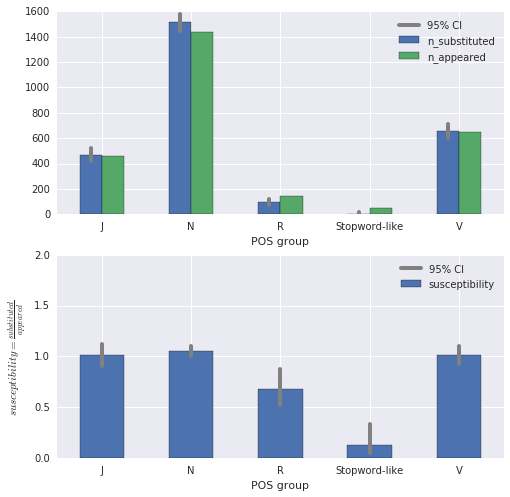

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['N', 'R', 'Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2]
     Target NOT different from H_0 (p > 0.01)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


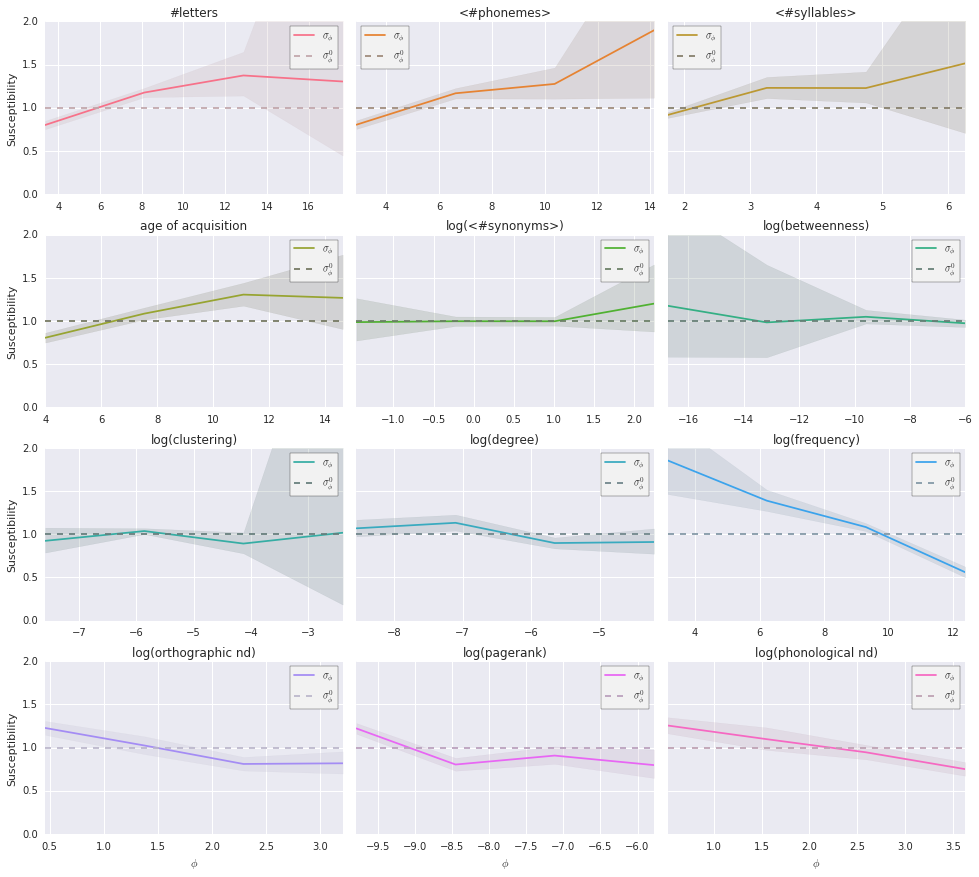

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3, 4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


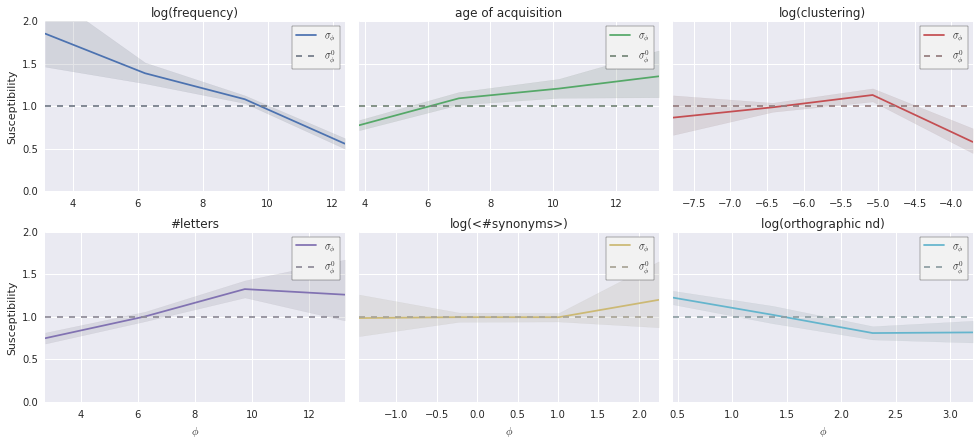

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 2] out of region: [1, 2]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


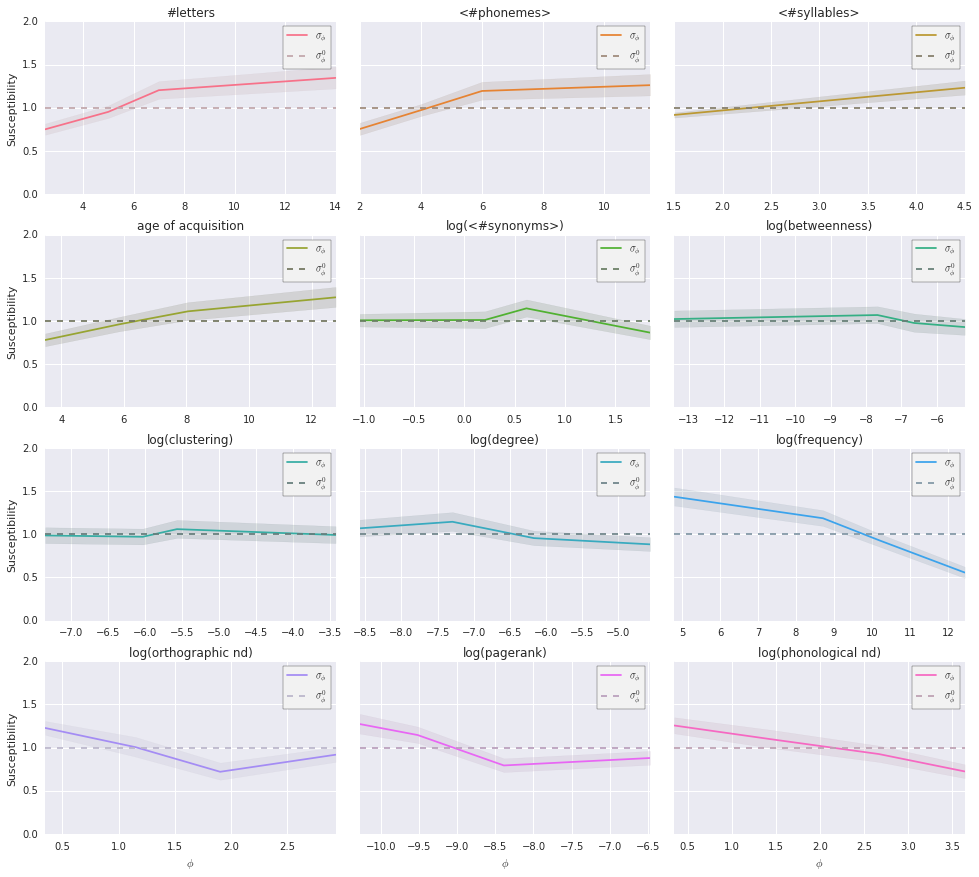

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


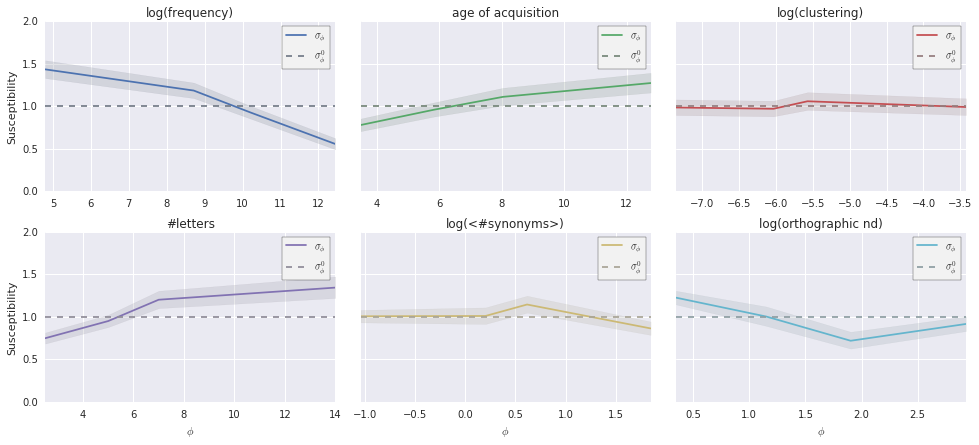

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


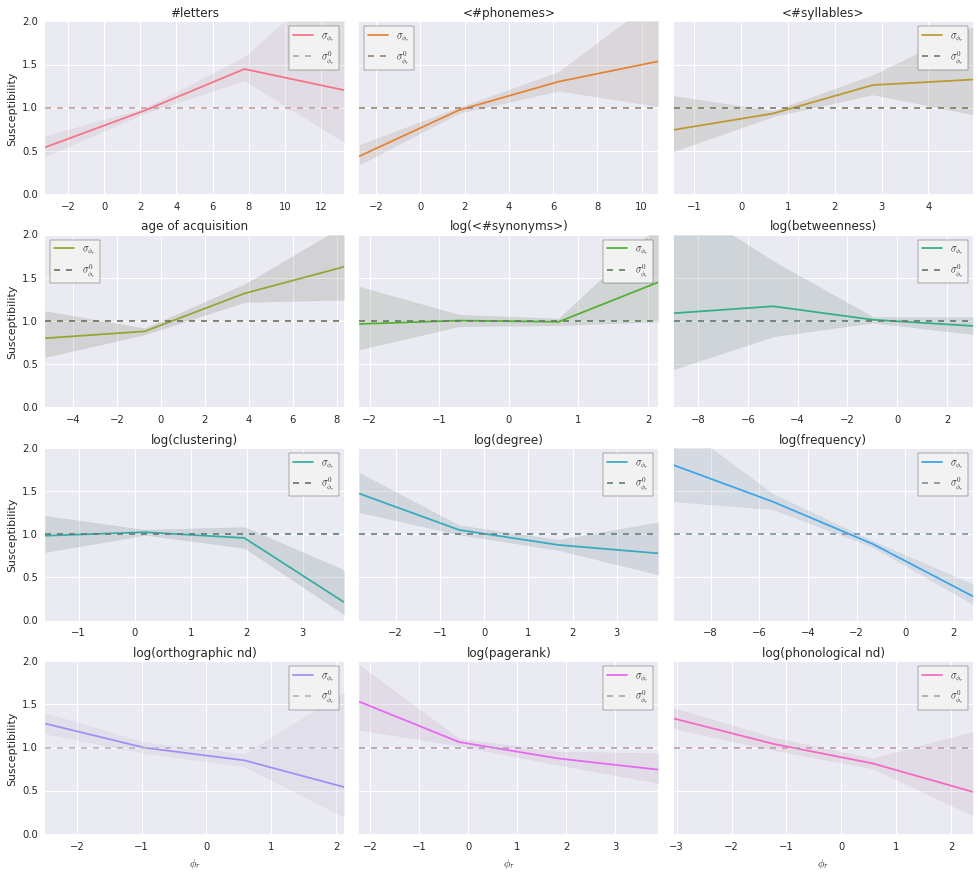

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]



----------
clustering
----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]


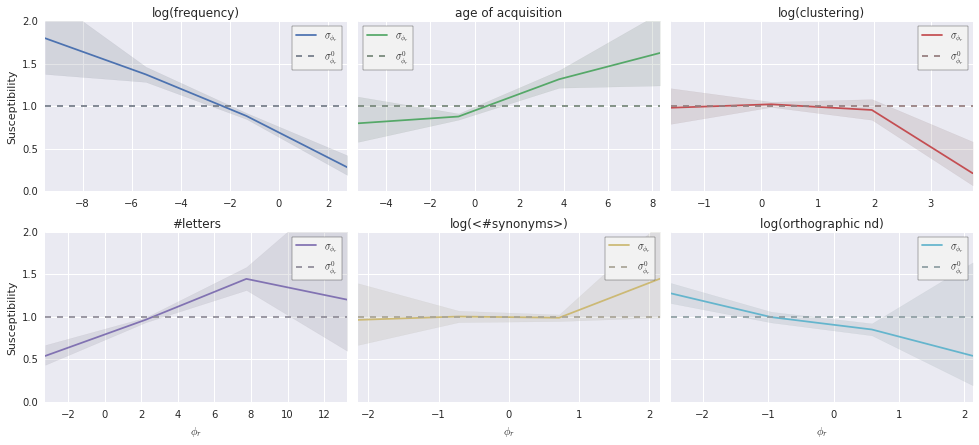

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 3] out of region: [1, 2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 3] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 3] out of region: [1, 3]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2]
     Target NOT different from H_0 (p > 0.01)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


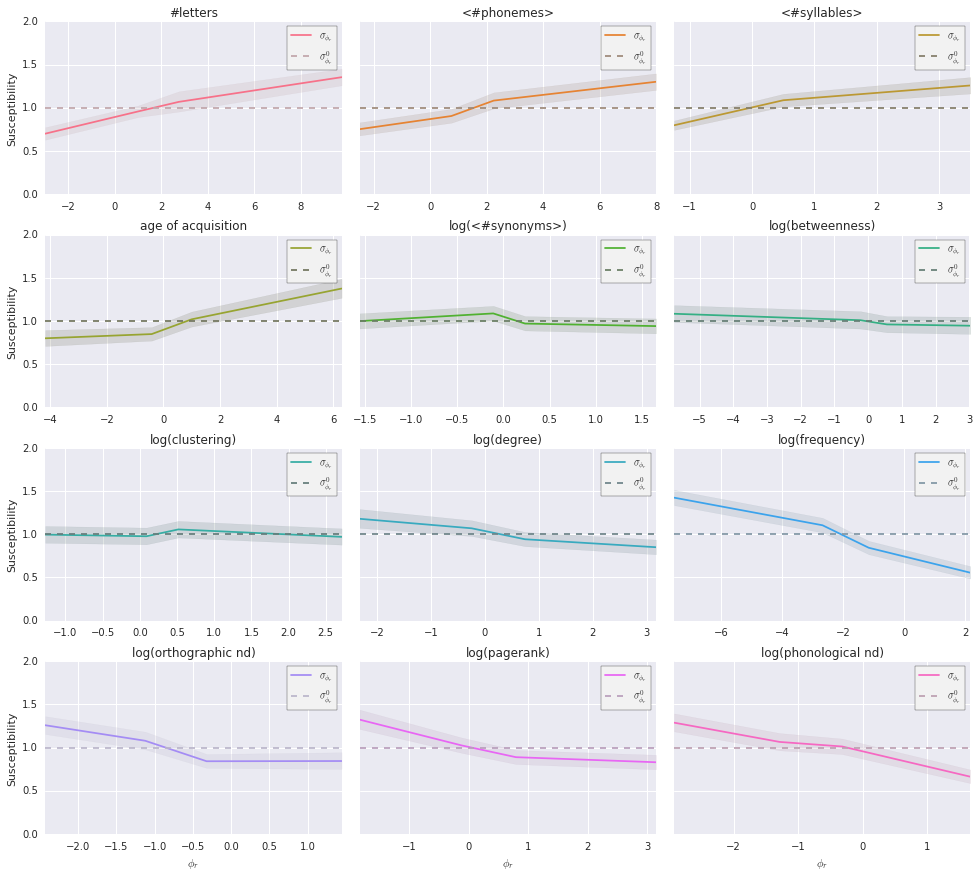

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2]
     Target NOT different from H_0 (p > 0.01)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]


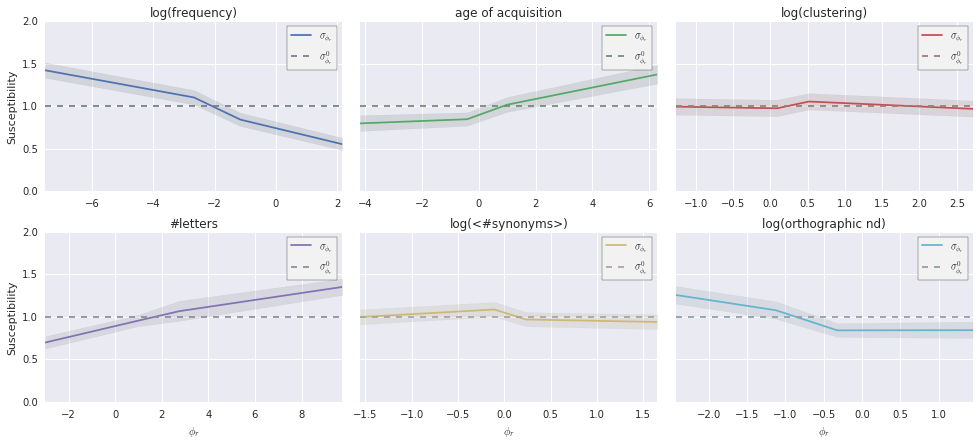

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)



-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


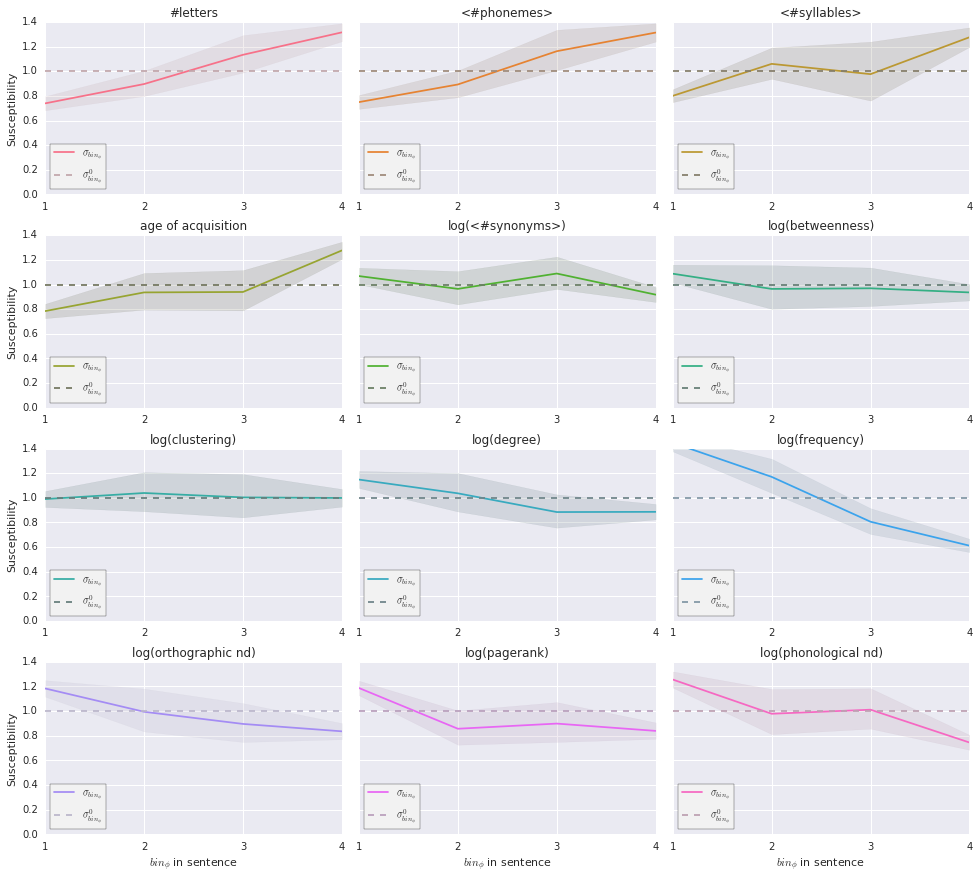

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------
synonyms_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


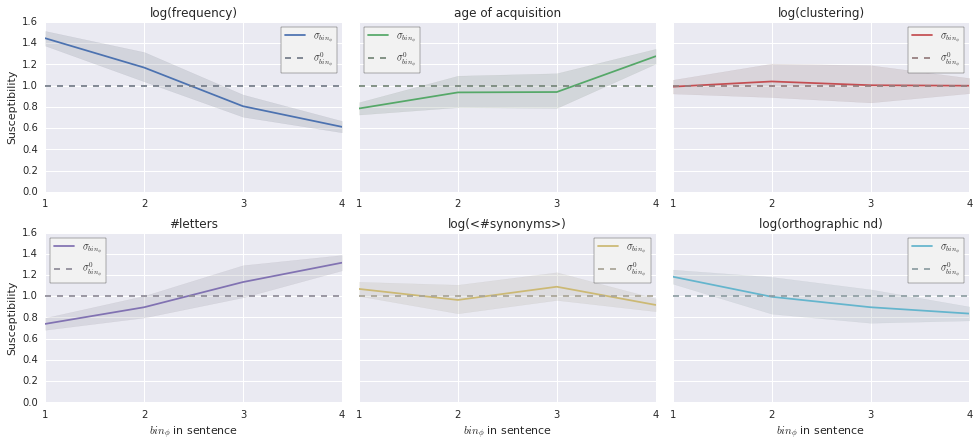

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



-----------
betweenness
-----------
     Target NOT different from H_0 (p > 0.05)



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]



--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


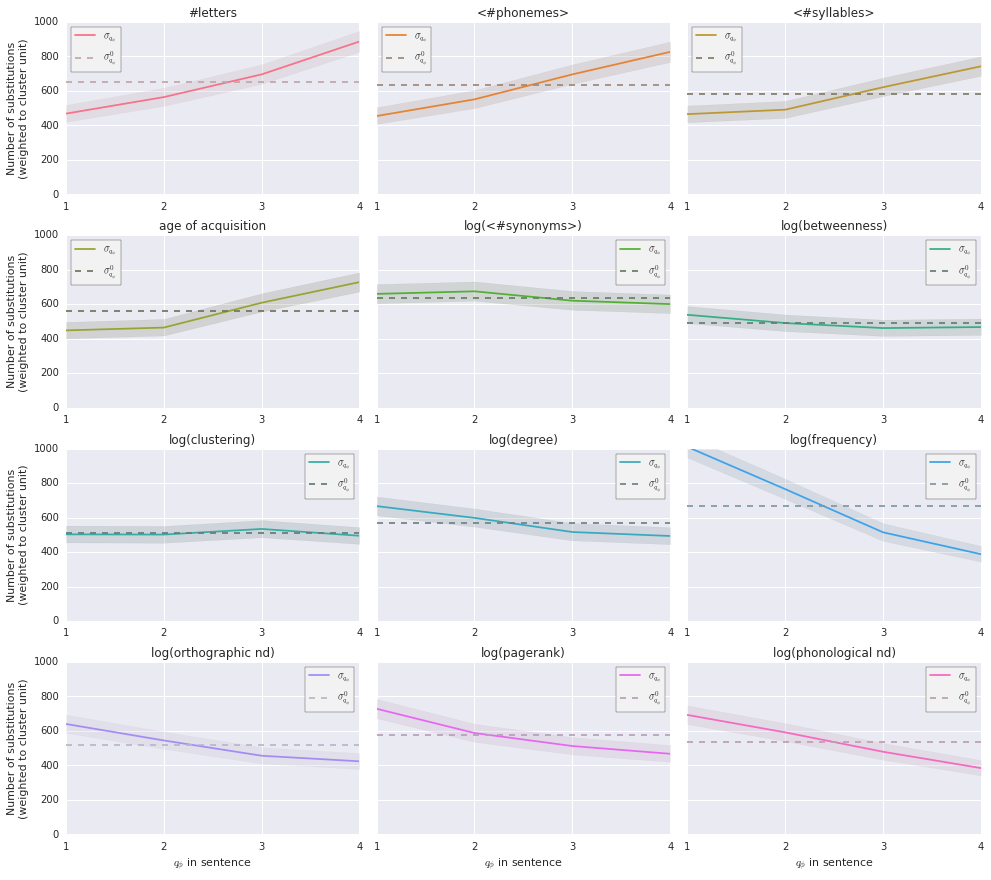

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]



---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)



-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


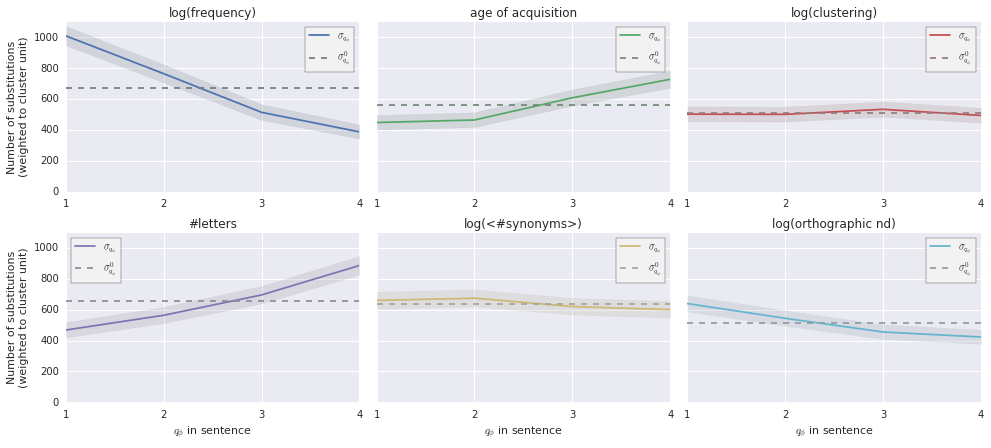

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 191033 word measures (divided into training and prediction sets)


57.38% of words well predicted (non-random at p = 1e-323)
Precision = 0.32
Recall = 0.52

Coefficients:
intercept                                             2.657135
global_frequency                                     -0.110902
global_aoa                                           -0.554580
global_letters_count                                  0.069277
global_orthographic_density                           0.023083
global_frequency * global_aoa                         0.033847
global_frequency * global_letters_count              -0.036828
global_frequency * global_orthographic_density       -0.017062
global_aoa * global_letters_count                     0.037517
global_aoa * global_orthographic_density              0.031000
global_letters_count * global_orthographic_density   -0.001054
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 191033 word measures (divided into training and prediction sets)



65.56% of words well predicted (non-random at p = 1e-323)
Precision = 0.40
Recall = 0.54

Coefficients:


intercept                                                        -0.285574
sentence-rel_frequency                                           -0.136154
sentence-rel_aoa                                                 -0.016342
sentence-rel_letters_count                                       -0.009893
sentence-rel_orthographic_density                                 0.169140
sentence-rel_frequency * sentence-rel_aoa                         0.007520
sentence-rel_frequency * sentence-rel_letters_count              -0.000599
sentence-rel_frequency * sentence-rel_orthographic_density        0.052292
sentence-rel_aoa * sentence-rel_letters_count                     0.051413
sentence-rel_aoa * sentence-rel_orthographic_density              0.063321
sentence-rel_letters_count * sentence-rel_orthographic_density    0.005445
dtype: float64


**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 191033 word measures (divided into training and prediction sets)



63.13% of words well predicted (non-random at p = 1e-323)
Precision = 0.38
Recall = 0.58

Coefficients:


intercept                                                         -5.304778
sentence-rel_frequency                                            -0.877253
sentence-rel_aoa                                                  -0.349226
sentence-rel_letters_count                                         0.376251
sentence-rel_orthographic_density                                  0.830102
global_frequency                                                   0.760406
global_aoa                                                        -0.584773
global_letters_count                                               0.492025
global_orthographic_density                                        0.992315
sentence-rel_frequency * sentence-rel_aoa                         -0.084536
sentence-rel_frequency * sentence-rel_letters_count               -0.023504
sentence-rel_frequency * sentence-rel_orthographic_density         0.078012
sentence-rel_frequency * global_frequency                          0.004887
sentence-rel

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 191033 word measures (divided into training and prediction sets)



63.95% of words well predicted (non-random at p = 1e-323)
Precision = 0.39
Recall = 0.59

Coefficients:
intercept                                                      -0.015315
bins-global_frequency                                          -0.050684
bins-global_aoa                                                -0.383808
bins-global_letters_count                                      -0.172077
bins-global_orthographic_density                               -0.910033
bins-global_frequency * bins-global_aoa                         0.520952
bins-global_frequency * bins-global_letters_count              -0.384261
bins-global_frequency * bins-global_orthographic_density       -0.289590
bins-global_aoa * bins-global_letters_count                     0.103705
bins-global_aoa * bins-global_orthographic_density             -0.348279
bins-global_letters_count * bins-global_orthographic_density    1.182204
dtype: float64


**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 191033 word measures (divided into training and prediction sets)



63.98% of words well predicted (non-random at p = 1e-323)
Precision = 0.38
Recall = 0.54

Coefficients:
intercept                                                                 2.005054
quantiles-global_frequency                                               -1.661854
quantiles-global_aoa                                                     -0.361240
quantiles-global_letters_count                                            2.424642
quantiles-global_orthographic_density                                    -2.458464
quantiles-global_frequency * quantiles-global_aoa                        -0.116363
quantiles-global_frequency * quantiles-global_letters_count              -0.230271
quantiles-global_frequency * quantiles-global_orthographic_density        1.920784
quantiles-global_aoa * quantiles-global_letters_count                     0.161592
quantiles-global_aoa * quantiles-global_orthographic_density              0.345376
quantiles-global_letters_count * quantiles-global_orthographic_de

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 191033 word measures (divided into training and prediction sets)



70.06% of words well predicted (non-random at p = 1e-323)
Precision = 0.43
Recall = 0.30

Coefficients:
intercept                                                                   0.659545
bins-sentence-rel_frequency                                                -0.420385
bins-sentence-rel_aoa                                                      -0.409110
bins-sentence-rel_letters_count                                            -0.200080
bins-sentence-rel_orthographic_density                                      0.659545
bins-sentence-rel_frequency * bins-sentence-rel_aoa                         0.115030
bins-sentence-rel_frequency * bins-sentence-rel_letters_count              -0.023394
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density       -0.420385
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                     0.509026
bins-sentence-rel_aoa * bins-sentence-rel_orthographic_density             -0.409110
bins-sentence-rel_letters_count * bins-senten

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 191033 word measures (divided into training and prediction sets)



54.35% of words well predicted (non-random at p = 2e-159)
Precision = 0.34
Recall = 0.70

Coefficients:
intercept                                                                             0.567081
quantiles-sentence-rel_frequency                                                      0.077287
quantiles-sentence-rel_aoa                                                           -0.358621
quantiles-sentence-rel_letters_count                                                 -0.220058
quantiles-sentence-rel_orthographic_density                                          -0.219526
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                         0.060532
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count              -0.223382
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density       -0.020983
quantiles-sentence-rel_aoa * quantiles-sentence-rel_letters_count                     0.160754
quantiles-sentence-rel_aoa * quantiles-s

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 191033 word measures (divided into training and prediction sets)



60.25% of words well predicted (non-random at p = 1e-323)
Precision = 0.34
Recall = 0.50

Coefficients:


intercept                                                                -0.192757
in-sentence-bins_frequency                                               -0.200563
in-sentence-bins_aoa                                                     -0.001707
in-sentence-bins_letters_count                                            0.180367
in-sentence-bins_orthographic_density                                     0.152120
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.045791
in-sentence-bins_frequency * in-sentence-bins_letters_count              -0.030169
in-sentence-bins_frequency * in-sentence-bins_orthographic_density        0.034553
in-sentence-bins_aoa * in-sentence-bins_letters_count                     0.059916
in-sentence-bins_aoa * in-sentence-bins_orthographic_density              0.060978
in-sentence-bins_letters_count * in-sentence-bins_orthographic_density   -0.179154
dtype: float64


### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 2201 aggregated word measures



Variance explained by first 2 components (mle-estimated): [ 0.69178064  0.17570401]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.370482  0.563990
aoa            0.738713 -0.302752
letters_count  0.563068  0.768281


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 2201 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.62751719  0.20170017]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.488868  0.626036
aoa            0.646036 -0.208172
letters_count  0.586213  0.751494
